### Kaggle Housing Price Competition

- [Run in Google Colab](https://colab.research.google.com/github/druce/iowa/blob/master/iowa)
- [Competition leaderboard](https://www.kaggle.com/c/home-data-for-ml-course/leaderboard)
- [Data set discussion](http://jse.amstat.org/v19n3/decock.pdf)
- [Data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [1]:
from itertools import product
import operator        
import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pdf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, lars_path, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# pointer to scaler I want to use to easily swap scalers
use_transform = RobustScaler

# not used
def mytransform():
    return QuantileTransformer(output_distribution='normal')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#!conda install -y -conda-forge  xgboost 
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

#!conda install -y -c conda-forge lightgbm
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#!conda install -y -c districtdatalabs yellowbrick
from yellowbrick.features import JointPlotVisualizer, ParallelCoordinates
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

#!conda install -y -c conda-forge mlxtend
from mlxtend.regressor import StackingCVRegressor

import ipywidgets as widgets
from IPython.display import clear_output
pd.options.display.max_columns=None
#pd.options.display.max_rows=None

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

print(datetime.datetime.now())



2019-06-04 23:52:19.174174


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu

### 1. Import

In [2]:
# import train data
datadir = "https://raw.githubusercontent.com/druce/iowa/master/data/"
datafile = datadir + "train.csv"
df_raw = pd.read_csv(datafile)
print(df_raw.shape)
display(df_raw.head())

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Initial exploration

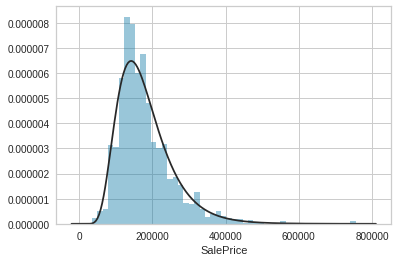

In [3]:
response = 'SalePrice'
sns.distplot(df_raw[response], kde=False, fit=stats.lognorm);


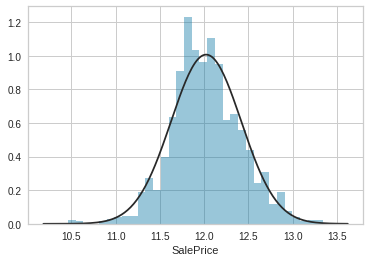

In [4]:
sns.distplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), kde=False, fit=stats.norm);


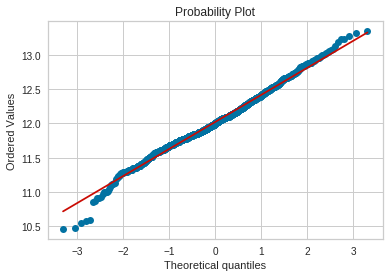

In [5]:
res = stats.probplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), plot=plt);

In [6]:
widget_cats = []
widget_nums = []

for col in df_raw.columns:
    if col == response:
        continue
    if df_raw[col].dtype == np.dtype('O'):
        widget_cats.append(col)
    elif len(df_raw[col].value_counts()) <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'Id', 'LotArea', 'LotFrontage', 'MasVnrArea', 

Dropdown(description='Variable:', options=('1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'E…

Dropdown(description='Color by:', index=47, options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCo…

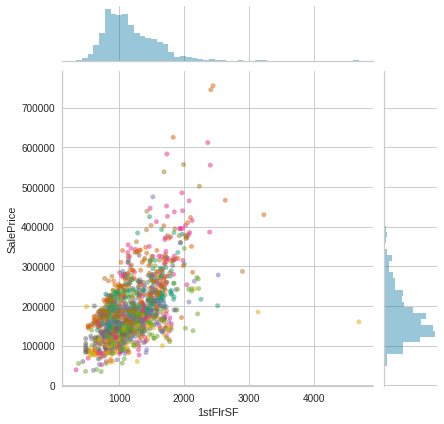

In [7]:
# interactive widget for continuous variables
df = df_raw
def on_value_change1(change):
    do_refresh(change['new'], gColor)

def on_value_change2(change):
    do_refresh(gVar, change['new'])

def do_refresh(var=widget_nums[0], colorby="Neighborhood"):

    global gVar
    gVar = var
    global gColor
    gColor = colorby
    
    clear_output()
    dropdown1 = widgets.Dropdown(
        options=widget_nums,
        value=var,
        description='Variable:',
        disabled=False,)
    display(dropdown1)

    dropdown1.observe(on_value_change1, names='value')

    dropdown2 = widgets.Dropdown(
        options=widget_cats,
        value=colorby,
        description='Color by:',
        disabled=False,)
    display(dropdown2)
    dropdown2.observe(on_value_change2, names='value')
    
    z = df.loc[~df[response].isna()]

    norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
    
    colordict = {k: i for i, k in enumerate(z[colorby].unique())}
    
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  joint_kws={"color": z[colorby].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )

do_refresh()
    


Dropdown(description='Cat:', options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExpos…

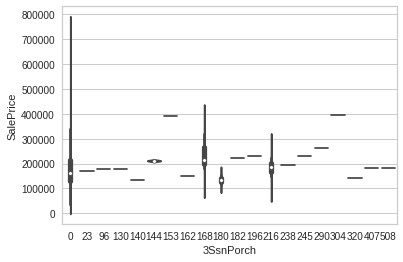

In [8]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
    

In [9]:
# import test data
datafile = datadir + "test.csv"
df_test = pd.read_csv(datafile)
df_test[response]=np.nan
df_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [10]:
# concatenate train and test for feature engineering across both
df_raw=pd.concat((df_raw, df_test)).set_index('Id')
print(df_raw.shape)

(2919, 80)


### 2. Scrub

In [11]:
df_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Per docs
23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables 

Nominal (categorical)
- MS SubClass
- MS Zoning
- Street
- Alley
- Land Contour
- Lot Config
- Neighborhood
- Condition 1
- Condition 2
- Bldg Type
- House Style
- Roof Style 
- Roof Matl
- Exterior 1
- Exterior 2
- Mas Vnr Type
- Foundation
- Heating
- Central Air
- Garage Type
- Misc Feature
- Sale Type
- Sale Condition

Ordinal (categorical but map to numerical, like Po/Fa/TA/Gd/Ex)
- Lot Shape
- Utilities
- Land Slope
- Overall Qual
- Overall Cond
- Exter Qual
- Exter Cond
- Bsmt Qual
- Bsmt Cond
- Bsmt Exposure
- BsmtFin Type 1
- BsmtFinType 2
- HeatingQC
- Electrical
- KitchenQual
- Functional
- FireplaceQu
- Garage Finish 
- Garage Qual
- Garage Cond
- Paved Drive
- Pool QC
- Fence

Discrete (int)
- Year Built
- Year Remod/Add
- Bsmt Full Bath
- Bsmt Half Bath
- Full Bath
- Half Bath
- Bedroom
- Kitchen
- TotRmsAbvGrd
- Fireplaces
- Garage Yr Blt 
- Garage Cars
- Mo Sold
- Yr Sold

Continuous (float)
- Lot Frontage
- Lot Area
- Mas Vnr Area
- BsmtFin SF 1
- BsmtFin SF 2
- Bsmt Unf SF
- Total Bsmt SF
- 1st Flr SF
- 2nd Flr SF
- Low Qual Fin SF
- Gr Liv Area
- Garage Area
- Wood Deck SF
- Open Porch SF
- Enclosed Porch
- 3-Ssn Porch
- Screen Porch
- Pool Area
- Misc Val

Response
- SalePrice


In [12]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
               'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
           'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence',]

numerical = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
             'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
             'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 
             
             'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',  'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

response='SalePrice'

print(df_raw.shape)
print(len(categorical))
print(len(ordinal))
print(len(numerical))
df_raw = df_raw[categorical + ordinal + numerical]
print(df_raw.shape)

(2919, 80)
23
23
34
(2919, 80)


In [13]:
df_raw.head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,SBrkr,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,NaN,NaN,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,Detchd,NaN,WD,Abnorml,IR1,AllPub,Gtl,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


In [14]:
# remove sf > 4000 per docs, http://jse.amstat.org/v19n3/decock.pdf
df= df_raw.loc[~((df_raw['GrLivArea'] > 4000) & (~df_raw[response].isna()))]


#### Map categorical to int

In [15]:
# map all the columns listed as ordinal to int
# per http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# map these 9 quality label cols to int

# should write an OrdinalEncoder that 
#   orders categorical levels by increasing response
#   takes an NA argument -> mode, round mean, min, max
#   1. find correctly sorted categorical levels
#   2. fillna using appropriate val
#   3. run OrdinalEncoders using sorted levels

qdict = {
    'Po' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4,
    np.nan : 2
}

qcols = ['ExterQual',
         'ExterCond',
         'BsmtQual',
         'BsmtCond',
         'HeatingQC',
         'KitchenQual',
         'GarageQual',
         'GarageCond',
         'FireplaceQu'         
        ]

# these values are very rare (<=5), roll poor->fair, excellent->good
df.loc[df['ExterCond']=='Po', 'ExterCond'] = 'Fa'
df.loc[df['BsmtCond']=='Po', 'BsmtCond'] = 'Fa'
df.loc[df['HeatingQC']=='Po', 'HeatingQC'] = 'Fa'
df.loc[df['GarageQual']=='Po', 'GarageQual'] = 'Fa'
df.loc[df['GarageQual']=='Ex', 'GarageQual'] = 'Gd'
df.loc[df['GarageCond']=='Ex', 'GarageCond'] = 'Gd'

for col in qcols:
    print(col)
    print(df[col].value_counts())
    df.loc[:, col] = df[col].apply(lambda q: qdict[q])
    df.loc[:, col] = df[col].astype(int)
    print(df[col].value_counts())

ExterQual
TA    1798
Gd     978
Ex     104
Fa      35
Name: ExterQual, dtype: int64
2    1798
3     978
4     104
1      35
Name: ExterQual, dtype: int64
ExterCond
TA    2534
Gd     299
Fa      70
Ex      12
Name: ExterCond, dtype: int64
2    2534
3     299
1      70
4      12
Name: ExterCond, dtype: int64
BsmtQual
TA    1283
Gd    1209
Ex     254
Fa      88
Name: BsmtQual, dtype: int64
2    1364
3    1209
4     254
1      88
Name: BsmtQual, dtype: int64
BsmtCond
TA    2602
Gd     122
Fa     109
Name: BsmtCond, dtype: int64
2    2684
3     122
1     109
Name: BsmtCond, dtype: int64
HeatingQC
Ex    1489
TA     857
Gd     474
Fa      95
Name: HeatingQC, dtype: int64
4    1489
2     857
3     474
1      95
Name: HeatingQC, dtype: int64
KitchenQual
TA    1492
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64
2    1493
3    1151
4     201
1      70
Name: KitchenQual, dtype: int64
GarageQual
TA    2600
Fa     129
Gd      27
Name: GarageQual, dtype: int64
2    2759
1     129
3 

In [16]:
print(df['LandSlope'].value_counts())

slope_dict = {
    'Gtl': 0,
    'Mod' : 1,
    'Sev' : 2,
}

df['LandSlope'] = df['LandSlope'].apply(lambda q: slope_dict[q])

print(df['LandSlope'].value_counts())

Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64
0    2774
1     125
2      16
Name: LandSlope, dtype: int64


In [17]:
print(df['GarageFinish'].value_counts())

garagefinish_dict = {
    np.nan : 0,
    'Unf': 1,
    'RFn' : 2,
    'Fin' : 3,
}
df['GarageFinish'] = df['GarageFinish'].apply(lambda q: garagefinish_dict[q])

print(df['GarageFinish'].value_counts())

Unf    1230
RFn     811
Fin     715
Name: GarageFinish, dtype: int64
1    1230
2     811
3     715
0     159
Name: GarageFinish, dtype: int64


In [18]:
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

print(df['BsmtExposure'].value_counts())

BsmtExposure_dict = {
    np.nan : 0,
    'No' : 1,
    'Mn' : 2, 
    'Av' : 3, 
    'Gd' : 4
}
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda q: BsmtExposure_dict[q])

print(df['BsmtExposure'].value_counts())


No    1904
Av     417
Gd     273
Mn     239
Name: BsmtExposure, dtype: int64
1    1904
3     417
4     273
2     239
0      82
Name: BsmtExposure, dtype: int64


In [19]:
#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only

print(df['Functional'].value_counts())

functional_dict = {
    np.nan:  4,
    'Sev':   0,
    'Maj1':  0,
    'Maj2':  0,
    'Mod':   1,
    'Min2':  2,
    'Min1':  3,
    'Typ' :  4,
}
df['Functional'] = df['Functional'].apply(lambda q: functional_dict[q])

print(df['Functional'].value_counts())


Typ     2713
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64
4    2715
2      70
3      65
1      35
0      30
Name: Functional, dtype: int64


In [20]:
#        NA	No Basement
#        Unf	Unfinshed
#        LwQ	Low Quality
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        ALQ	Average Living Quarters
#       GLQ	Good Living Quarters

print(df['BsmtFinType1'].value_counts())

bsmt_fintype_dict = {
    np.nan : 0,
    'NA' : 0,
    'Unf' : 1,
    'LwQ' : 2,
    'BLQ' : 3,
    'Rec' : 4,
    'ALQ' : 5,
    'GLQ' : 6
}

df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda q: bsmt_fintype_dict[q])

print(df['BsmtFinType1'].value_counts())

print(df['BsmtFinType2'].value_counts())
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda q: bsmt_fintype_dict[q])
print(df['BsmtFinType2'].value_counts())



Unf    851
GLQ    845
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
1    851
6    845
5    429
4    288
3    269
2    154
0     79
Name: BsmtFinType1, dtype: int64
Unf    2489
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
1    2489
4     105
2      87
0      80
3      68
5      52
6      34
Name: BsmtFinType2, dtype: int64


In [21]:
#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
print(df['LotShape'].value_counts())
 
lotshape_dict = {
    np.nan : 0,
    'Reg' : 0,
    'IR1' : 1,
    'IR2' : 2,
    'IR3' : 2,
}    

df['LotShape'] = df['LotShape'].apply(lambda q: lotshape_dict[q])

print(df['LotShape'].value_counts())


Reg    1859
IR1     965
IR2      76
IR3      15
Name: LotShape, dtype: int64
0    1859
1     965
2      91
Name: LotShape, dtype: int64


In [22]:
#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed

print(df['Electrical'].value_counts())
 
elec_dict = {
    np.nan : 0,
    'Mix' : 0,
    'FuseP' : 0,
    'FuseF' : 2,
    'FuseA' : 3,
    'SBrkr' : 4,
}    

df['Electrical'] = df['Electrical'].apply(lambda q: elec_dict[q])

print(df['Electrical'].value_counts())


SBrkr    2667
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64
4    2667
3     188
2      50
0      10
Name: Electrical, dtype: int64


In [23]:
# Paved Drive (Ordinal): Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
        
print(df['PavedDrive'].value_counts())
 
pave_dict = {
    'N' : 0,
    'P' : 1,
    'Y' : 2,
}    

df['PavedDrive'] = df['PavedDrive'].apply(lambda q: pave_dict[q])

print(df['PavedDrive'].value_counts())


Y    2637
N     216
P      62
Name: PavedDrive, dtype: int64
2    2637
0     216
1      62
Name: PavedDrive, dtype: int64


In [24]:
# Fence (Ordinal): Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

print(df['Fence'].value_counts())

fence_dict = {
    np.nan : 0,
    'MnWw' : 1,
    'GdWo' : 2,
    'MnPrv' : 3,
    'GdPrv' : 4,
}

df['Fence'] = df['Fence'].apply(lambda q: fence_dict[q])

print(df['Fence'].value_counts())


MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
0    2345
3     328
4     118
2     112
1      12
Name: Fence, dtype: int64


In [25]:
# Map these categorical vars 

#        1Story	One story
#        SFoyer	Split Foyer
#        SLvl	Split Level
#     1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished

print(df['HouseStyle'].value_counts())

story_dict = {
    '1Story' : 0,
    'SFoyer' : 1,
    'SLvl'   : 2,
    '1.5Unf' : 3,
    '1.5Fin' : 4,
    '2Story' : 5,
    '2.5Unf' : 6,
    '2.5Fin' : 7    
}

df['HouseStyle'] = df['HouseStyle'].apply(lambda q: story_dict[q])

print(df['HouseStyle'].value_counts())


1Story    1471
2Story     868
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64
0    1471
5     868
4     314
2     128
1      83
6      24
3      19
7       8
Name: HouseStyle, dtype: int64


In [26]:
df['CentralAir'] = df['CentralAir'] == 'Y' 
df['CentralAir'] = df['CentralAir'].astype(int)

In [27]:
df.head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,0,AllPub,0,7,5,3,2,3,2,1,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,0,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,1,Attchd,NaN,WD,Normal,0,AllPub,0,6,8,2,2,3,2,4,5,1,4,4,2,4,2,2,2,2,2,NaN,0,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,AllPub,0,7,5,3,2,3,2,2,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,5,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,1,Detchd,NaN,WD,Abnorml,1,AllPub,0,7,5,2,2,2,3,1,5,1,3,4,3,4,3,1,2,2,2,NaN,0,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,AllPub,0,8,5,3,2,3,2,3,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


#### Impute / fill NAs

In [28]:
# For garage, basement, bathroom/half, assume if missing then this feature is not present

for col in ['GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath']:
    print(col)
    df[col].fillna(0, inplace=True)
for col in ['GarageYrBlt']:
    print(col)
    df[col].fillna(df['YearBuilt'], inplace=True)
    df[col]=df[col].astype(int)
for col in ['GarageType']:
    print(col)
    df[col].fillna('None', inplace=True)

df.loc[:, 'BsmtFullBath']=df['BsmtFullBath'].astype(int)
df.loc[:, 'BsmtHalfBath']=df['BsmtHalfBath'].astype(int)
df.loc[:, 'GarageCars']=df['GarageCars'].astype(int)


GarageArea
GarageCars
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageType


In [29]:
for col in df.columns:
    print(col)
    print (df[col].value_counts())
    print()

MSSubClass
20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

MSZoning
RL         2261
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Street
Pave    2903
Grvl      12
Name: Street, dtype: int64

Alley
Grvl    120
Pave     78
Name: Alley, dtype: int64

LandContour
Lvl    2620
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64

LotConfig
Inside     2132
Corner      508
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
B

In [30]:
df.loc[df['MSSubClass'] == 150]

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2819,150,RL,Pave,NaN,HLS,Inside,ClearCr,Norm,Norm,Twnhs,4,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,1,Basment,NaN,WD,Normal,0,AllPub,0,7,5,3,2,3,2,2,6,1,2,4,3,4,2,3,3,2,2,NaN,0,1980,1981,1,0,2,1,2,1,7,0,1980,1,4,2006,NaN,1700,0.0,397.0,0.0,33.0,430.0,880,680,140,1700,450.0,188,36,0,0,200,0,0,NaN


In [31]:
display(df.groupby(['MSSubClass']).mean()[[response]].reset_index().sort_values(response))
display(df.groupby(['MSSubClass']).count()[[response]].reset_index().sort_values(response))

,MSSubClass,SalePrice
1,30,95829.724638
14,180,102300.000000
3,45,108591.666667
15,190,129613.333333
10,90,133541.076923
13,160,138647.380952
4,50,143302.972222
9,85,147810.000000
2,40,156125.000000
6,70,166772.416667


,MSSubClass,SalePrice
12,150,0
2,40,4
14,180,10
3,45,12
7,75,16
9,85,20
15,190,30
10,90,52
8,80,58
6,70,60


In [32]:
#        020	1-STORY 1946 & NEWER ALL STYLES
#        030	1-STORY 1945 & OLDER
#        040	1-STORY W/FINISHED ATTIC ALL AGES
#        045	1-1/2 STORY - UNFINISHED ALL AGES
#        050	1-1/2 STORY FINISHED ALL AGES
#        060	2-STORY 1946 & NEWER
#        070	2-STORY 1945 & OLDER
#        075	2-1/2 STORY ALL AGES
#        080	SPLIT OR MULTI-LEVEL
#        085	SPLIT FOYER
#        090	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

print(df['MSSubClass'].value_counts())

MSSubClass_dict = {
    40 : 70,
    45 : 45,
    150 : 160,
    180 : 30,
    20 : 20,
    60 : 60,
    50 : 50,
    120 : 120,
    30 : 30,
    160 : 160,
    70 : 70,
    80 : 80,
    90 : 90,
    190 : 190,
    85 : 85,
    75 : 75,
}

df['MSSubClass'] = df['MSSubClass'].apply(lambda q: MSSubClass_dict[q])

print(df['MSSubClass'].value_counts())


20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
20     1079
60      571
50      287
120     182
30      156
70      134
160     129
80      118
90      109
190      61
85       48
75       23
45       18
Name: MSSubClass, dtype: int64


In [33]:
# fill missing MSZoning using most popular value by subclass
df.loc[:, 'MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing LotFrontage using median value by Neighborhood
# could also impute using LotArea
df.loc[:, 'LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [34]:
# impute categorical strings

oimpute = {'MSZoning' : 'RL',
           'MasVnrType' : 'None',
           'Utilities': 'AllPub',
           'Exterior1st': 'VinylSd',
           'Exterior2nd': 'VinylSd',
           'BsmtExposure' : 'No',
           'BsmtFinType1': 'Unf',
           'BsmtFinType2': 'Unf',
           'Electrical' : 'SBrkr',
           'GarageType'  : 'Attchd',
           'GarageFinish' : 'Unf',
           'GarageCond' : 'TA',
           'Functional' : 'Typ',
           'SaleType': 'WD',
           'Alley': 'None',
           'FireplaceQu': 'TA',
           'PoolQC' : 'None',
           'Fence': 'Other',
           'MiscFeature': 'Other',
          }

def impute_strings(features, ocols, groupby):
    
    for col in ocols:
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col, 'missing', features[col].isna().sum())
            print(features[col].value_counts())
            if groupby:
                features[col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mode()[0]))
            features[col].fillna(oimpute[col], inplace=True)
    return features

ocols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t == np.dtype('O')])

df = impute_strings(df, ocols, None)

Alley missing 2717
Grvl    120
Pave     78
Name: Alley, dtype: int64
Exterior1st missing 1
VinylSd    1025
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
CBlock        2
Stone         2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64
Exterior2nd missing 1
VinylSd    1014
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64
MasVnrType missing 24
None       1741
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64
MiscFeature missing 2810
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
SaleType missing 1
WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw 

In [35]:
# impute mean for missing floats - mean by neighborhood

def impute_floats(features, fcols, groupby='Neighborhood', response=response):

    for col in fcols:
        if col == response:
            continue
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col)
            print('missing', features[col].isna().sum())
            display(df.loc[df[col].isna()])
            if groupby:
                features.loc[:,col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                features.loc[:,col] = features[col].mean()
                
    return features

# set this to 0 since MasVnrType is always 'None' when MasVnrArea is nan
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

# set this to 0 since these do not seem to have a basement
df.loc[df['BsmtFinSF1'].isna(), 'BsmtFinSF1'] = 0
df.loc[df['BsmtFinSF2'].isna(), 'BsmtFinSF2'] = 0
df.loc[df['BsmtUnfSF'].isna(), 'BsmtUnfSF'] = 0
df.loc[df['TotalBsmtSF'].isna(), 'TotalBsmtSF'] = 0

fcols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t in numeric_dtypes])

df = impute_floats(df, fcols, 'Neighborhood')

In [36]:
# map all remaining categorical variables to ints by grouping and sorting by mean SalePrice
# i.e. categorical var with lowest average saleprice maps to 0, next lowest is 1, etc.
# numeric values potentially allow interaction features

labelencoded = []

def myLabelEncoder(df, column, target, order_only=True, verbose=True):
    
    temp_df= df.loc[~df[target].isna()][[column, target]] \
        .groupby(column) \
        .agg(np.mean) \
        .sort_values(target) \
        .reset_index()
    
    if order_only == True:
        mapdict = dict(zip(temp_df[column], temp_df.index))
    else:
        mapdict = dict(zip(temp_df[column], temp_df[target]))

    mapdict[np.nan] = np.nan

    if verbose:
        print(mapdict)
    
    return df[column].apply(lambda q: mapdict[q])

for col in df.columns:
    if df[col].dtype in numeric_dtypes:
        continue
    else:
        df[col] = myLabelEncoder(df, col, response)
        labelencoded.append(col)

{'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4, nan: nan}
{'Grvl': 0, 'Pave': 1, nan: nan}
{'Grvl': 0, 'Pave': 1, 'None': 2, nan: nan}
{'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3, nan: nan}
{'Inside': 0, 'Corner': 1, 'FR2': 2, 'FR3': 3, 'CulDSac': 4, nan: nan}
{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NPkVill': 9, 'NAmes': 10, 'Mitchel': 11, 'SawyerW': 12, 'NWAmes': 13, 'Gilbert': 14, 'Blmngtn': 15, 'CollgCr': 16, 'Crawfor': 17, 'ClearCr': 18, 'Somerst': 19, 'Veenker': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24, nan: nan}
{'Artery': 0, 'RRAe': 1, 'Feedr': 2, 'Norm': 3, 'RRAn': 4, 'RRNe': 5, 'RRNn': 6, 'PosN': 7, 'PosA': 8, nan: nan}
{'RRNn': 0, 'Artery': 1, 'Feedr': 2, 'RRAn': 3, 'Norm': 4, 'RRAe': 5, 'PosA': 6, 'PosN': 7, nan: nan}
{'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, 'TwnhsE': 3, '1Fam': 4, nan: nan}
{'Gambrel': 0, 'Gable': 1, 'Mansard': 2, 'Flat': 3, 'Hip': 4, 'Shed': 5, nan: nan}
{'

#### Roll up rare categorical values

In [37]:
print(df['OverallQual'].value_counts())
df.loc[df['OverallQual'] == 1, 'OverallQual'] = 2
print(df['OverallQual'].value_counts())

print(df['OverallCond'].value_counts())
df.loc[df['OverallCond'] == 1, 'OverallCond'] = 2
print(df['OverallCond'].value_counts())


5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      13
1       4
Name: OverallQual, dtype: int64
5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      17
Name: OverallQual, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      17
Name: OverallCond, dtype: int64


In [38]:
# roll up low cardinality categorical variables

def rollup_low_cardinality(features, threshold):
    """Rollup least frequent categorical features, up to total threshold observations rolled up"""
    for col in features.columns:
        # skip numerics
        if (features[col].dtype in numeric_dtypes):
            continue
        
        print(col)
        counts = features[col].value_counts()
        howmany=0
        vals = []
        for i, (val, c) in reversed(list(enumerate(zip(list(counts.index), list(counts))))):
            if howmany + c < threshold:
                print(val, c)
                howmany += c
                vals += [val]
            else:
                break
        if len(vals) > 1:
            print ('Rollup', vals)
            for v in vals:
                features.loc[features[col] == v, col] = 'Rollup'
        print()
    return features

def rollup_low_cardinality_int(df, preds, threshold):
    """Rollup least frequent ordered features
    if < threshold, roll into next higher
    if highest, roll into next lower
    """
    for col in preds:
        print(col)
        counts = df[col].value_counts()
        counts = df[col].value_counts().sort_index()
        print(counts)
        indexlist = list(counts.index)
        for i, val in enumerate(indexlist):
            if counts[val] < threshold:
                if val < len(indexlist)-1:
                    # not last
                    print(val, '=>', indexlist[i+1])
                    df.loc[df[col]==val, col] = indexlist[i+1]
                    # update counts so you don't roll up if now > thresh
                    counts[indexlist[i+1]] += counts[indexlist[i]]
                else:
                    print(val, '=>', indexlist[i-1])
                    df.loc[df[col]==val, col] = indexlist[i-1]
                    #no need to update since last

    return df

df = rollup_low_cardinality(df, 25)

intcats = ['LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
           'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
           'Heating','GarageType','SaleType','SaleCondition','LotShape','LandSlope',
           'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','Electrical',
           'KitchenQual','GarageFinish','GarageQual','GarageCond','PavedDrive',
           'BsmtFullBath','HalfBath','KitchenAbvGr','Fireplaces',]

df = rollup_low_cardinality_int(df, intcats, 5)


LandContour
0     115
1    2620
2      60
3     120
Name: LandContour, dtype: int64
LotConfig
0    2132
1     508
2      85
3      14
4     176
Name: LotConfig, dtype: int64
Neighborhood
0      37
1      93
2      30
3     108
4     192
5     239
6     151
7      10
8      48
9      23
10    443
11    114
12    125
13    131
14    165
15     28
16    267
17    103
18     44
19    182
20     24
21     72
22     51
23     69
24    166
Name: Neighborhood, dtype: int64
Condition1
0      92
1      28
2     163
3    2509
4      50
5       6
6       9
7      38
8      20
Name: Condition1, dtype: int64
Condition2
0       2
1       5
2      13
3       1
4    2886
5       1
6       4
7       3
Name: Condition2, dtype: int64
0 => 1
3 => 4
5 => 6
7 => 6
BldgType
0      62
1     109
2      96
3     227
4    2421
Name: BldgType, dtype: int64
RoofStyle
0      22
1    2309
2      11
3      20
4     548
5       5
Name: RoofStyle, dtype: int64
RoofMatl
0       1
1    2874
2       1
3      23
4       9
5

#### Engineer

In [39]:
# Compute additional features

#df['MS SubClass']=df['MS SubClass'].astype(str)
df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['PorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['BsmtFullBath'].fillna(0, inplace=True)
df.loc[df['BsmtFullBath'] > 2, 'BsmtFullBath'] = 2
df['BsmtHalfBath'].fillna(0, inplace=True)
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df.loc[df['TotalBath'] > 5, 'TotalBath'] = 5
df['BsmtBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df.loc[df['BsmtBath'] > 2, 'BsmtBath'] = 2

df['BsmtFullBath'] = df['BsmtFullBath'].astype(int)
df.drop(columns=['BsmtHalfBath'], inplace=True)

df['AvgBltRemod'] = (df['YearBuilt'] + df['YearRemodAdd']) / 2
df['AvgBltRemod'] = 2010 - df['AvgBltRemod'] 
df['YearBuilt'] = 2010 - df['YearBuilt'] 
df['YearRemodAdd'] = 2010 - df['YearRemodAdd'] 
df['GarageYrBlt'] = 2010 - df['GarageYrBlt'] 

# cap and floor outliers
df.loc[df['KitchenAbvGr'] > 2, 'KitchenAbvGr'] = 2
df.loc[df['GarageCars'] >= 4, 'GarageCars'] = 4
df.loc[df['TotRmsAbvGrd'] <=3, 'TotRmsAbvGrd'] = 3
df.loc[df['BedroomAbvGr'] > 6, 'BedroomAbvGr'] = 6
df.loc[df['TotRmsAbvGrd'] > 12, 'TotRmsAbvGrd'] = 12
df.loc[df['Fireplaces'] > 3, 'Fireplaces'] = 3

# fix 1 bad value
df.loc[df['GarageYrBlt'] < 0, 'GarageYrBlt'] = 0

# Booleans
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Ratios
df['LivAreaRatio'] = df['TotalSF'] / df['LotArea']
df['BedRatio'] = df['GrLivArea'] / df['BedroomAbvGr']
df.loc[df['BedRatio'] > 2500, 'BedRatio'] = 2500
df['GarageRatio']  = df['GarageCars'] / df['BedroomAbvGr']
df.loc[df['GarageRatio'] > 5, 'GarageRatio'] = 5
df['BathRatio'] = df['TotalBath'] /  df['BedroomAbvGr']
df.loc[df['BathRatio'] > 5, 'BathRatio'] = 5
df['LotRatio'] = df['LotArea'] / df['LotFrontage']
df.loc[df['LotRatio'] > 500, 'LotRatio'] = 500
df['FireBathRatio'] = df['Fireplaces'] / df['TotalBath']
df.loc[df['FireBathRatio'] > 1.5, 'FireBathRatio'] = 1.5

# df['OverallQualRatio'] = (df['OverallQual'] + 1) / (df['OverallCond'] + 1)
# df['ExterQualRatio'] = (df['ExterQual'] + 1) / (df['ExterCond'] + 1)
# df['BsmtQualRatio'] = (df['BsmtQual'] + 1) / (df['BsmtCond']   + 1)
# df['GarageQualRatio'] = (df['GarageQual'] + 1) / (df['GarageCond']   + 1)

# df['Gr Liv Area x Overall Qual'] = df['Gr Liv Area'] * df['Overall Qual']

# interaction features, have residual correlation and also look reasonable
df['TotalSF x OverallQual x OverallCond'] = df['TotalSF'] * df['OverallQual'] * df['OverallCond']
df['TotalSF x OverallQual x Functional'] = df['TotalSF'] * df['OverallQual'] * df['Functional']
df['AvgBltRemod x Functional x TotalFinSF'] = df['AvgBltRemod'] * df['Functional'] * df['TotalFinSF']

df['TotalSF x OverallQual'] = df['TotalSF'] * df['OverallQual']
df['TotalSF x OverallCond'] = df['TotalSF'] * df['OverallCond']
df['TotalFinSF x Functional'] = df['Functional'] * df['TotalFinSF']
#df['OverallQual x OverallCond'] = df['OverallQual'] * df['OverallCond']
df['Functional x OverallQual'] = df['Functional'] * df['OverallQual']
df['AvgBltRemod x OverallCond'] = df['AvgBltRemod'] * df['OverallCond']
df['AvgBltRemod x TotalFinSF'] = df['AvgBltRemod'] * df['TotalFinSF']
#df['YearBuilt x OverallCond'] = df['YearBuilt'] * df['OverallCond']
df['OverallCond x AvgBltRemod'] = df['OverallCond'] * df['AvgBltRemod']

df['BsmtFinSF x BsmtQual'] = df['BsmtFinSF'] * df['BsmtQual']
df['BsmtFinSF x BsmtBath'] = df['BsmtFinSF'] * df['BsmtBath']
df['KitchenAbvGr x KitchenQual'] = df['KitchenAbvGr'] * df['KitchenQual']
df['GarageCars x GarageYrBlt'] = df['GarageCars'] * df['GarageYrBlt']

#df['ExterQual x ExterCond x Exterior1st'] = df['ExterQual'] * df['ExterCond'] * df['Exterior1st']
#df['BsmtQual x BsmtCond x BsmtFinSF'] = df['BsmtQual'] * df['BsmtCond'] * df['BsmtFinSF']
df['GarageQual x GarageCond x GarageCars'] = df['GarageQual'] * df['GarageCond'] * df['GarageCars']

df['HeatingQC x Heating'] = df['HeatingQC'] * df['Heating']
df['KitchenQual x KitchenAbvGr'] = df['KitchenQual'] * df['KitchenAbvGr']
df['FireplaceQu x Fireplaces'] = df['FireplaceQu'] * df['Fireplaces']
         


In [40]:
# add sequential month index to capture any trend
def add_trend(features, datecols=['YrSold', 'MoSold']):
    yearmo = features[datecols]

    yearmo = yearmo.sort_values(datecols) \
        .groupby(datecols) \
        .first()\
        .reset_index() \
        .reset_index() \
        .rename(columns={'index': 'monthnum'})

    display(yearmo.head(5))
    display(yearmo.tail(5))

    print(features.shape)
    # merge messes up the order, so reset index, merge, apply index, sort index
    features.reset_index(inplace=True)
    
    features = features.merge(yearmo, on=datecols)
    features.set_index('Id', inplace=True)
    features.sort_index(inplace=True)
    print(features.shape)
    return features

df = add_trend(df)
df.drop(columns=['YrSold'], inplace=True)


,monthnum,YrSold,MoSold
0,0,2006,1
1,1,2006,2
2,2,2006,3
3,3,2006,4
4,4,2006,5


,monthnum,YrSold,MoSold
50,50,2010,3
51,51,2010,4
52,52,2010,5
53,53,2010,6
54,54,2010,7


(2915, 113)
(2915, 114)


#### Transform (logs, squares)

In [41]:
# we test variables below to see if log or square has higher correlation with response and transform accordingly

transformsquare = ['BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF x BsmtQual', 'Functional x OverallQual',]

for col in transformsquare:
    print(col)
    df[col] = df[col] ** 2
    df.rename(columns={col : 'sq' + col}, inplace=True)


BsmtUnfSF
2ndFlrSF
BsmtFinSF
BsmtFinSF x BsmtQual
Functional x OverallQual


In [42]:
transformlog = ['LotArea', 'YearBuilt', 'GrLivArea', 'GarageYrBlt', 'TotalFinSF', 
                #'ExterCond' 'BsmtFinType2', 'BsmtExposure',
                'LivAreaRatio', 'BedRatio', 'GarageRatio', 'BathRatio', 'LotRatio', 
                #'OverallQualRatio','ExterQualRatio','BsmtQualRatio','GarageQualRatio',
                'TotalSF x OverallQual', 'KitchenAbvGr x KitchenQual', 
                'TotalSF x OverallCond',#'OverallQual x OverallCond',
                'AvgBltRemod x OverallCond',
                'AvgBltRemod x TotalFinSF',#'YearBuilt x OverallCond',
                'OverallCond x AvgBltRemod',
                'KitchenQual x KitchenAbvGr','FireplaceQu x Fireplaces',
               ]

for col in transformlog:
    print(col)
    df[col] = np.log1p(df[col])
    df.rename(columns={col : 'log' + col}, inplace=True)


LotArea
YearBuilt
GrLivArea
GarageYrBlt
TotalFinSF
LivAreaRatio
BedRatio
GarageRatio
BathRatio
LotRatio
TotalSF x OverallQual
KitchenAbvGr x KitchenQual
TotalSF x OverallCond
AvgBltRemod x OverallCond
AvgBltRemod x TotalFinSF
OverallCond x AvgBltRemod
KitchenQual x KitchenAbvGr
FireplaceQu x Fireplaces


#### Fix highly skewed predictors

In [43]:
### unskew, shrink outliers

def unskew_features(features, high_skew=0.5):
    
    numeric_col_ix = [i for i in features.columns if features[i].dtype in numeric_dtypes]

    skew_features = features[numeric_col_ix].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > high_skew]
    skew_index = high_skew.index

    for i in skew_index:
        print(i)
        try:
            features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
        except:
            pass

    return features

# doesn't seem to help, we already transformed with logs and squares
# df = unskew_features(df)

### 3. Review and Setup

In [44]:
# transform target to log target, expm1 at end
df[response] = np.log1p(df[response])

In [45]:
# drop these based on ProfileReport

dropcols = ['3SsnPorch',
            'EnclosedPorch',
            'OpenPorchSF',
            'ScreenPorch',
            'WoodDeckSF',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'LowQualFinSF',
            'MiscVal',
            'PoolArea',
            'Street', 
           ]

df.drop(columns=dropcols, inplace=True)
print(df.shape)


(2915, 102)


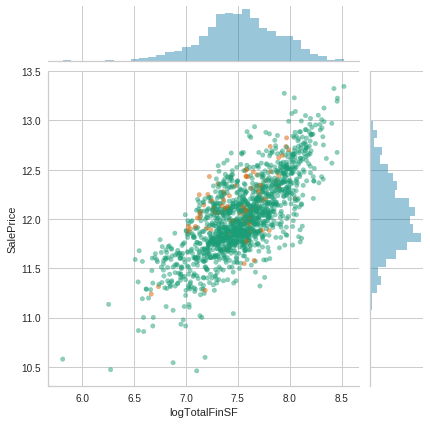

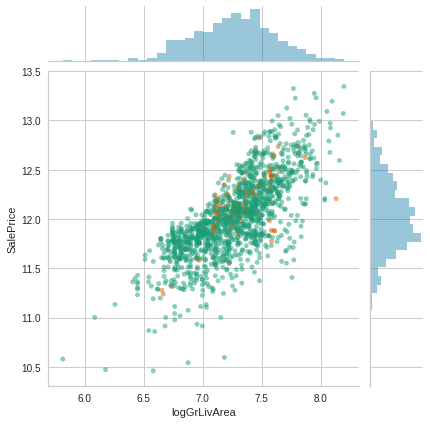

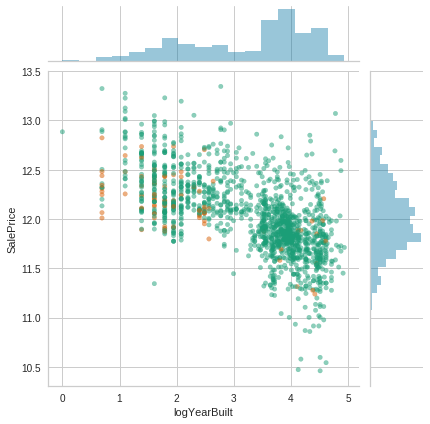

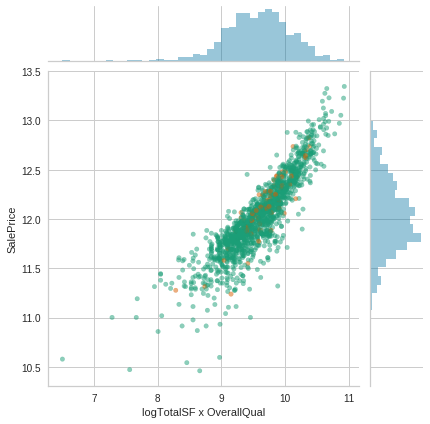

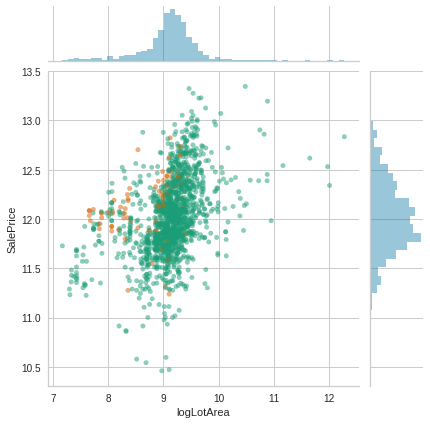

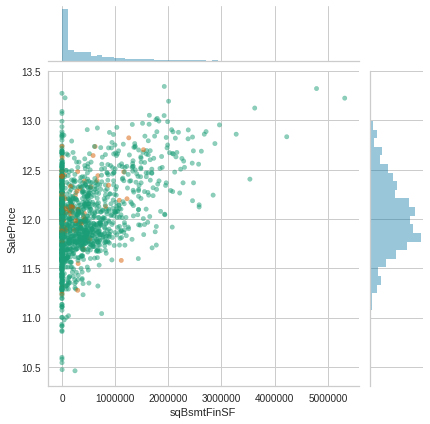

In [46]:
# few charts

z = df.loc[~df[response].isna()]

norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
colordict = {k: i for i, k in enumerate(z['MSZoning'].unique())}

for var in ['logTotalFinSF','logGrLivArea','logYearBuilt','logTotalSF x OverallQual','logLotArea','sqBsmtFinSF',]:
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  joint_kws={"color": z['MSZoning'].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )
    


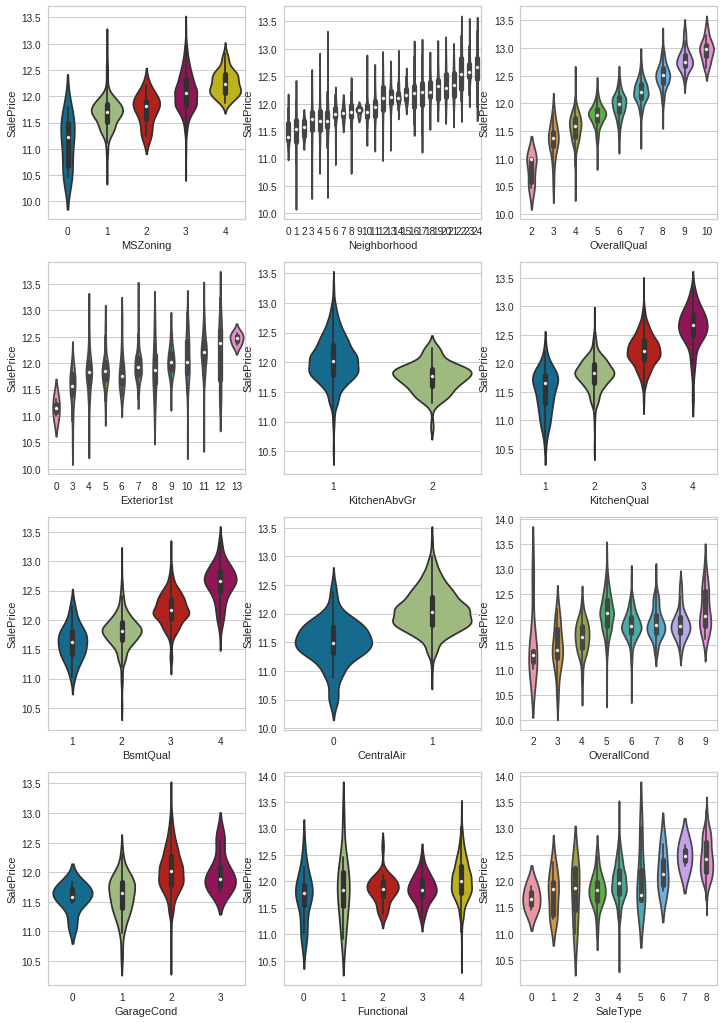

In [47]:
fig, ax = plt.subplots(figsize=(12,18), ncols=3, nrows=4)

for i, var in enumerate(['MSZoning','Neighborhood','OverallQual','Exterior1st','KitchenAbvGr','KitchenQual',
                         'BsmtQual', 'CentralAir','OverallCond','GarageCond','Functional','SaleType',]):
    sns.violinplot(x=var, y=response, data=z, ax = ax[i // 3][i % 3])    


In [48]:
widget_cats = []
widget_nums = []

for col in df.columns:
    if col == response:
        continue
    cardinality = len(df[col].value_counts())
    if cardinality <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireBathRatio', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageQual x GarageCond x GarageCars', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HeatingQC x Heating', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'TotRmsAbvGrd', 'TotalBath', 'Utilities', 'has2ndfloor', 'hasfireplace', 'haspool', 'logFireplaceQu x Fireplaces', 'logGarageRatio', 'logKitchenAbvGr x KitchenQual', 'logKitchenQual x KitchenAbvGr'

Dropdown(description='Variable:', options=('1stFlrSF', 'AvgBltRemod', 'AvgBltRemod x Functional x TotalFinSF',…

Dropdown(description='Color by:', index=47, options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCon…

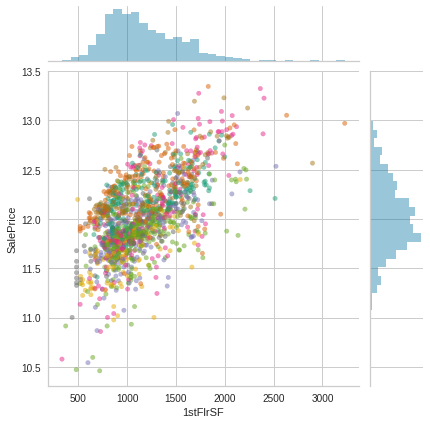

In [49]:
# interactive widget for continuous variables

do_refresh()
    


Dropdown(description='Cat:', options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposu…

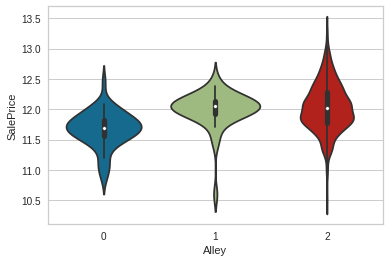

In [50]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
        

In [51]:
### compare correlations of log, linear, square, add transforms as necessary
### make categorical if low cardinality

z = df.loc[~df[response].isna()]
for col in z.columns:
    if z[col].dtype not in numeric_dtypes:
        continue
    elif col==response:
        continue
    log = (np.corrcoef(np.log1p(z[col]), z[response])[0,1])
    linear = (np.corrcoef(z[col], z[response])[0,1])
    square = (np.corrcoef(z[col]**2, z[response])[0,1])
    print(col, 'log', log, 'linear', linear, 'square', square)
    

MSSubClass log -0.0004798907734951526 linear -0.04514451690638043 square -0.09328233312170445
MSZoning log 0.41753275148485824 linear 0.41279756852904714 square 0.3968974086646346
Alley log 0.16242653532499024 linear 0.15754606824608658 square 0.1454785444063308
LandContour log 0.16278764070540458 linear 0.15709534886644297 square 0.13402513591086052
LotConfig log 0.12785450847566468 linear 0.14424571916822732 square 0.1537406785470078
Neighborhood log 0.6886270727823947 linear 0.7420311981460962 square 0.7282914789507746
Condition1 log 0.1850577692219324 linear 0.18380549468895432 square 0.14073313864977835
Condition2 log 0.10212307960484668 linear 0.10726550305334924 square 0.10860889036903383
BldgType log 0.18116649123563208 linear 0.183155943702183 square 0.17511133594202238
HouseStyle log 0.11447612264187941 linear 0.1393572946258224 square 0.1696622861142495
RoofStyle log 0.20614395906459587 linear 0.20475409957822752 square 0.2027659110664456
RoofMatl log 0.09410713890389882 lin

In [52]:
# make these strings, forces dummification (could also just specify columns to dummify)
# transformstr = ['HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageQual', 'TotalBath', 'BsmtBath',  'HalfBath', 'MSSubClass',]

categorical_str = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig',
                   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                   'Foundation', 'Heating', 'CentralAir', 'GarageType', 'SaleType',
                   'SaleCondition', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond',
                   'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                   'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical',
                   'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                   'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 
                   'Fireplaces', 'GarageCars', 'MoSold', 'monthnum']

for col in df.columns:
    cardinality = df[col].value_counts().shape[0]
    if ((cardinality <= 4) and (cardinality > 2) or (col in labelencoded)):
        print(col)
        df[col] = df[col].apply(str)

        

MSZoning
Alley
LandContour
LotConfig
Neighborhood
Condition1
Condition2
BldgType
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Foundation
Heating
GarageType
MiscFeature
SaleType
SaleCondition
LotShape
Utilities
LandSlope
ExterQual
ExterCond
BsmtQual
BsmtCond
HeatingQC
Electrical
KitchenQual
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
BsmtFullBath
HalfBath
Fireplaces


In [53]:
# transform categorical variables to dummies
print(df.shape)
df = pd.get_dummies(df)
#drop_first doesn't help
#df = pd.get_dummies(df, drop_first=True)
print(df.shape)

(2915, 102)
(2915, 264)


In [54]:
# after dummifying, check for possible deletion or merger
low_variance = []

for i in df.columns:
    counts = df[i].value_counts()
    topval_count = counts.iloc[0]
    if topval_count / len(df) * 100 > 99.4:
        low_variance.append(i)

low_variance = list(low_variance)
low_variance

['haspool',
 'LotConfig_3',
 'Neighborhood_7',
 'Condition1_5',
 'Condition1_6',
 'Condition2_1',
 'Condition2_2',
 'Condition2_6',
 'RoofStyle_2',
 'RoofStyle_5',
 'RoofMatl_4',
 'RoofMatl_6',
 'Exterior1st_0',
 'Exterior1st_13',
 'Exterior2nd_12',
 'Exterior2nd_7',
 'Foundation_3',
 'Foundation_4',
 'Heating_1',
 'Heating_2',
 'GarageType_1',
 'MiscFeature_0',
 'MiscFeature_2',
 'MiscFeature_4',
 'SaleType_0',
 'SaleType_2',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'SaleCondition_0',
 'Utilities_0',
 'Utilities_1',
 'LandSlope_2',
 'ExterCond_4',
 'Electrical_0',
 'GarageCond_0',
 'PoolQC_0',
 'PoolQC_1',
 'PoolQC_2',
 'PoolQC_3',
 'Fireplaces_3']

In [55]:
# drop only >= 2911 identical
dropcols = []
for col in df.columns:
    most_frequent = df[col].value_counts().iloc[0]
    if most_frequent  >= 2911:
        dropcols.append(col)
        print(col, most_frequent)

df.drop(columns=dropcols, inplace=True)

Exterior1st_13 2912
MiscFeature_0 2911
MiscFeature_4 2914
Utilities_0 2914
Utilities_1 2914
PoolQC_1 2913
PoolQC_2 2912
PoolQC_3 2912


In [56]:
# split off train, test
df_test = df.loc[df[response].isna()]
print(df_test.shape)

df = df.loc[~df[response].isna()]
print(df.shape)

predictors = [p for p in df.columns if p not in [response]]

X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[response], test_size=.25)


(1459, 256)
(1456, 256)


### 4. Tune 

In [57]:
# use 10 kfolds for CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


In [58]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Train RMSE', np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('Train R-squared', r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('Train MAE', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    print()
    print('Test RMSE', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
    print('Test R-squared', r2_score(np.expm1(y_test), np.expm1(y_pred_test)))
    print('Test MAE', mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_test)))

def evaluate2(y_train, y_pred_train, prefix = "Train"):
    print('%s RMSE (log)' % prefix, np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('%s RMSE' % prefix, np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('%s R-squared' % prefix, r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('%s MAE' % prefix, mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    return r2_score(np.expm1(y_train), np.expm1(y_pred_train))

In [59]:
%%time
# linear regression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)

scores = np.sqrt(-cross_val_score(reg, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print()
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


Train RMSE 15779.301948585959
Train R-squared 0.9589626449486869
Train MAE 10596.62773812439

Test RMSE 18972.949572738373
Test R-squared 0.9315135321600523
Test MAE 13333.151881886144

CV Score 0.1138 (STD 0.0118)

CPU times: user 764 ms, sys: 12 ms, total: 776 ms
Wall time: 158 ms


alpha 0.0005623413251903491
Train RMSE 17488.999500495738
Train R-squared 0.9495880242276995
Train MAE 11434.244167012506

Test RMSE 17421.489494830643
Test R-squared 0.9422561641499243
Test MAE 12104.77166542753


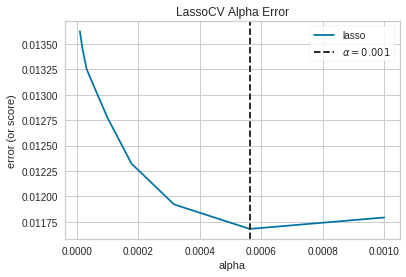

CPU times: user 10.9 s, sys: 144 ms, total: 11 s
Wall time: 2.21 s


In [60]:
%%time
# lasso, visualize with yellowbrick
scaler = use_transform()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)

#alphas = np.logspace(-5, 4, 19)
alphas = np.logspace(-5, -3, 9)
visualizer = AlphaSelection(LassoCV(alphas=alphas, max_iter=200000, cv=kfolds))
visualizer.fit(X_tr, y_train)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()

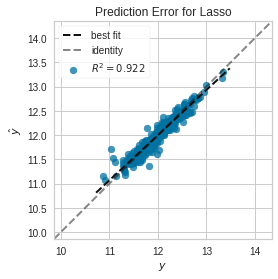

CPU times: user 1.08 s, sys: 20 ms, total: 1.1 s
Wall time: 219 ms


In [61]:
%%time
visualizer = PredictionError(Lasso(alpha=alpha))
visualizer.fit(X_tr, y_train)
visualizer.score(scaler.transform(X_test), y_test)
visualizer.poof()

In [62]:
%%time
# tune LassoCV search space
# note train error is worse when using lasso regularization but test is better
# regularization reduces overfitting

lasso = make_pipeline(use_transform(),
                      LassoCV(alphas=np.logspace(-4, -2, 11),
                              max_iter=100000,
                              cv=kfolds))

scores = np.sqrt(-cross_val_score(lasso, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

lasso.fit(X_train, y_train)

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)

print('alpha', lasso._final_estimator.alpha_)


CV Score 0.1059 (STD 0.0128)

Train RMSE 17620.653683622957
Train R-squared 0.9488261820891499
Train MAE 11519.028508807522

Test RMSE 17432.83199830867
Test R-squared 0.9421809498154136
Test MAE 12109.603990991278
alpha 0.000630957344480193
CPU times: user 27.3 s, sys: 272 ms, total: 27.6 s
Wall time: 5.53 s


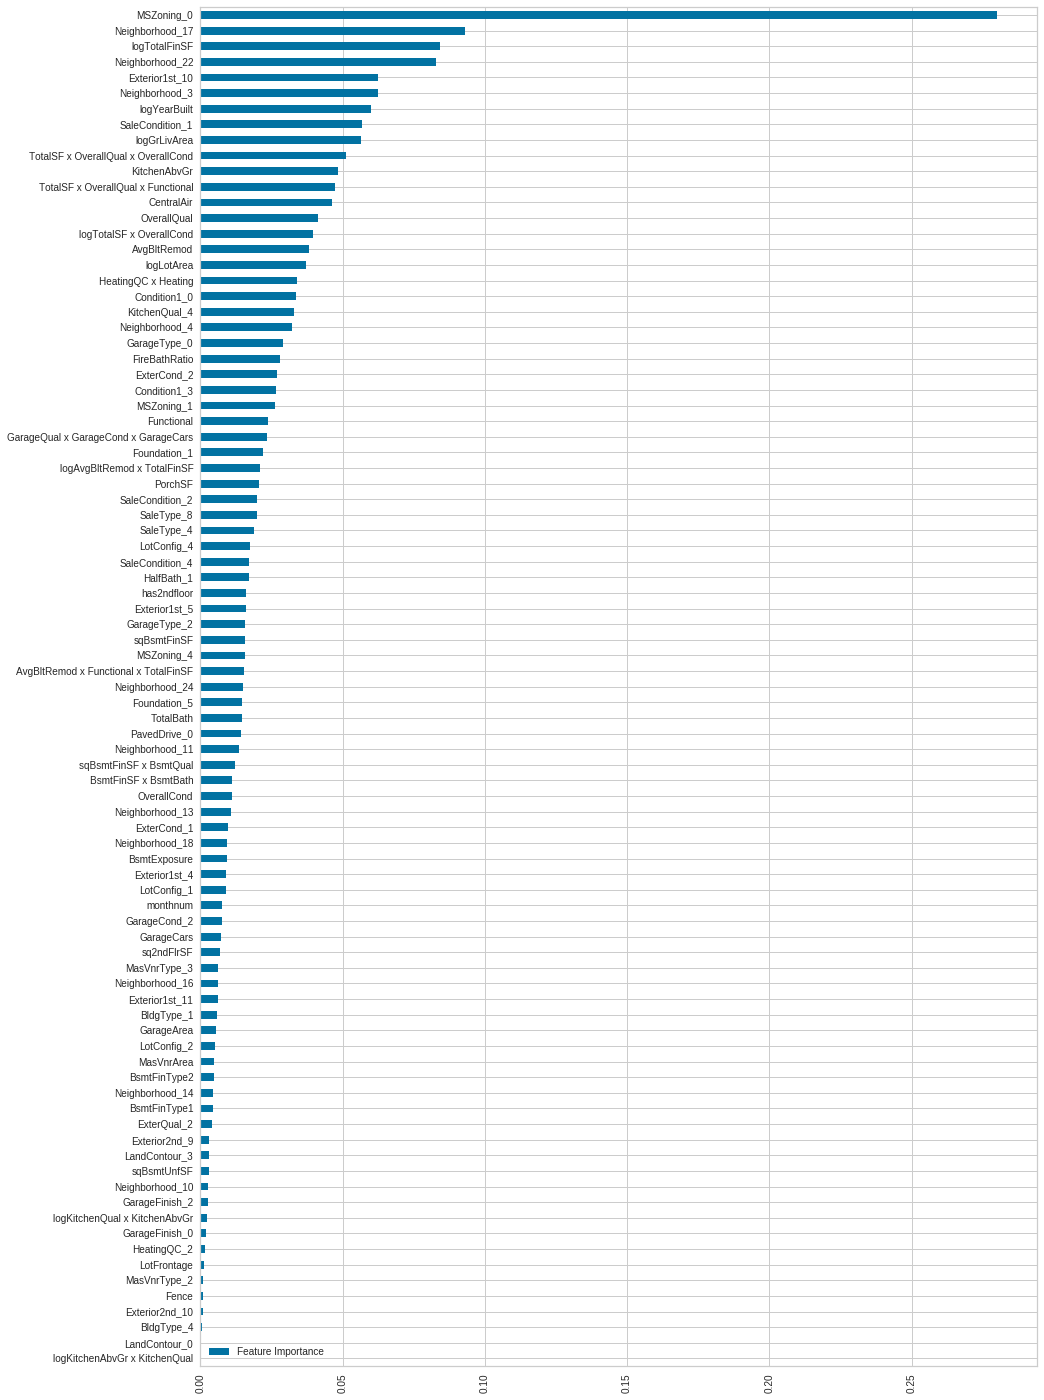

In [63]:
imp_lasso = pd.DataFrame({"Feature Importance" : lasso._final_estimator.coef_}, index=predictors)
imp_lasso["Feature Importance"]=abs(imp_lasso["Feature Importance"])
imp_lasso[imp_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

Train RMSE 16862.403150018963
Train R-squared 0.9531356363014515
Train MAE 11127.654765561612

Test RMSE 17301.07055805361
Test R-squared 0.9430516667242835
Test MAE 12009.075607567342
alpha 10.0


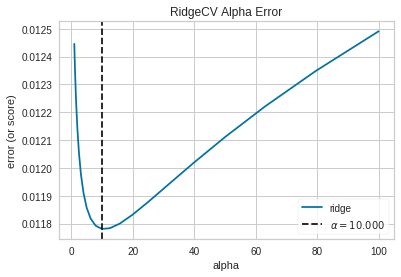

CPU times: user 648 ms, sys: 8 ms, total: 656 ms
Wall time: 158 ms


In [64]:
%%time
# visualize ridge with yellowbrick
scaler = use_transform()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)

#alphas = np.logspace(-2, 3, 11)
alphas = np.logspace(0, 2, 21)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
visualizer.poof()

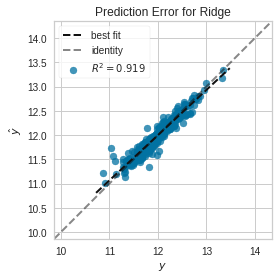

CPU times: user 532 ms, sys: 16 ms, total: 548 ms
Wall time: 110 ms


In [65]:
%%time
visualizer = PredictionError(Ridge(alpha=alpha))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [66]:
%%time
# tune RidgeCV search space
alphas = np.logspace(0, 2, 21)

ridge = make_pipeline(use_transform(),
                      RidgeCV(cv=kfolds, alphas=alphas))

scores = np.sqrt(-cross_val_score(ridge, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('alpha', ridge._final_estimator.alpha_)


CV Score 0.1071 (STD 0.0128)

Train RMSE 17218.172789936576
Train R-squared 0.9511372492922366
Train MAE 11324.421371908937

Test RMSE 17300.704400190432
Test R-squared 0.943054077194699
Test MAE 11893.547442886958
alpha 15.848931924611142
CPU times: user 52.6 s, sys: 800 ms, total: 53.4 s
Wall time: 10.7 s


In [67]:
%%time
# Tune ElasticNetCV search space for alphas and l1_ratio
print("ElasticNetCV")

elasticnet = make_pipeline(use_transform(),
                           ElasticNetCV(max_iter=100000, 
                                        #l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                        l1_ratio=np.linspace(0.6, 0.8, 21),
                                        alphas=np.logspace(-4, -2, 21),
                                        cv=kfolds))

scores = np.sqrt(-cross_val_score(elasticnet, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))

print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

elasticnet.fit(X_train, y_train)

y_pred_train = elasticnet.predict(X_train)
y_pred_test = elasticnet.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('l1_ratio', elasticnet._final_estimator.l1_ratio_)
print('alpha', elasticnet._final_estimator.alpha_)



ElasticNetCV
CV Score 0.1058 (STD 0.0129)

Train RMSE 17712.243096209375
Train R-squared 0.9482928124307548
Train MAE 11583.772963999494

Test RMSE 17457.974265026147
Test R-squared 0.942014052059241
Test MAE 12113.779699933963
l1_ratio 0.67
alpha 0.001
CPU times: user 11min 34s, sys: 9.45 s, total: 11min 43s
Wall time: 2min 35s


In [68]:
%%time
# tune KernelRidge
print("KernelRidge")

kralphas = np.logspace(-5,0,11)
kralpha = 0.03162277660168379

# linear, poly
# degree 1,2,3
coef0s = np.linspace(1,10, 19)
coef0=6

krdegrees = [1,2,3]
krdegree = 1

for i in [1]:

    kr = make_pipeline(use_transform(),
                       KernelRidge(alpha=kralpha, kernel='poly', degree=krdegree, coef0=coef0)
                      )
    print(kr)
    scores = np.sqrt(-cross_val_score(kr, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()

    kr.fit(X_train, y_train)

    y_pred_train = kr.predict(X_train)
    y_pred_test = kr.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
    
    

KernelRidge
Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('kernelridge',
                 KernelRidge(alpha=0.03162277660168379, coef0=6, degree=1,
                             gamma=None, kernel='poly', kernel_params=None))],
         verbose=False)
CV Score 0.1067 (STD 0.0125)

Train RMSE 16719.597747032945
Train R-squared 0.9539260509788505
Train MAE 11047.824702740212

Test RMSE 17320.47790481831
Test R-squared 0.9429238323302476
Test MAE 12063.184210905216
CPU times: user 2.85 s, sys: 64 ms, total: 2.91 s
Wall time: 728 ms


In [69]:
%%time
# tune SVR
print("SVR")

Cs = np.logspace(0,2,5)
C = 3.1622776601683795

epsilons = np.logspace(-5,0,11)
epsilon = 0.03162277660168379

svrgammas = np.logspace(-5,0,11)
svrgamma = 0.001

for i in [1]:

    svr = make_pipeline(use_transform(),
                        SVR(kernel='rbf', 
        #                        degree=3, 
                            gamma=svrgamma,
        #                        coef0=0.0, 
        #                        tol=0.001, 
                            C=C, 
                            epsilon=epsilon, 
        #                        shrinking=True, 
        #                        cache_size=200, 
        #                        verbose=False, 
        #                        max_iter=-1))
                           ))
    print(svr)
    
    scores = np.sqrt(-cross_val_score(svr, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()

    svr.fit(X_train, y_train)

    y_pred_train = svr.predict(X_train)
    y_pred_test = svr.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)

    print()


SVR
Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svr',
                 SVR(C=3.1622776601683795, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.03162277660168379, gamma=0.001, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)
CV Score 0.1058 (STD 0.0136)

Train RMSE 16287.586617662631
Train R-squared 0.956276263860345
Train MAE 9928.422965057553

Test RMSE 17209.622451304593
Test R-squared 0.943652098216389
Test MAE 11268.484997090978

CPU times: user 5.64 s, sys: 28 ms, total: 5.67 s
Wall time: 4.74 s


In [70]:
%%time
# tune Gradient Boost
print("Gradient Boost")
gbestimatorss = np.logspace(2,4,9)
gbestimators = 5623
gbdepth = 2
gblearnrate = 0.01

for i in range(1):
                           
    gb = GradientBoostingRegressor(n_estimators=int(gbestimators), 
                                   learning_rate=gblearnrate,
                                   max_depth=gbdepth, 
                                   max_features='sqrt',
                                   min_samples_leaf=16, 
                                   loss='huber', 
                                   subsample=0.8, 
                                   random_state=42)
    print(gb)
    
    scores = np.sqrt(-cross_val_score(gb, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()

    gb.fit(X_train, y_train)
    
    y_pred_train = gb.predict(X_train)
    y_pred_test = gb.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
    print()
    


Gradient Boost
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='huber', max_depth=2,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=16, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5623,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
CV Score 0.1080 (STD 0.0146)

Train RMSE 13689.879142445607
Train R-squared 0.9691110591988559
Train MAE 8357.120613423549

Test RMSE 19673.378131853467
Test R-squared 0.9263635332020688
Test MAE 12807.68621161711

CPU times: user 1min 5s, sys: 208 ms, total: 1min 6s
Wall time: 1min 6s


In [71]:
%%time
# tune XGBoost
print("XGBoost")
# XGboost - sophisticated decision tree model
# tuned sequentially
# no log1p

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 5623

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 3

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.55

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:
 
        xgb = XGBRegressor(
            objective='reg:linear',
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
        display(xgb)
        
        scores = np.sqrt(-cross_val_score(xgb, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
        
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()

xgb.fit(X_train, y_train.values.reshape(-1))
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)

XGBoost


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.15, gamma=0, importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=None, n_estimators=5623, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.55)

CV Score 0.1103 (STD 0.0141)

Train RMSE 5603.102509269249
Train R-squared 0.9948255889679024
Train MAE 4077.043211996337

Test RMSE 21181.766929277397
Test R-squared 0.9146390119403122
Test MAE 13455.120299622264
CPU times: user 11min 26s, sys: 9.77 s, total: 11min 36s
Wall time: 1min 22s


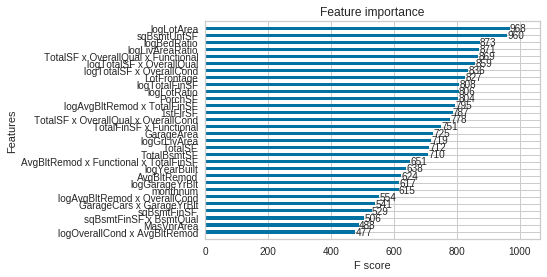

In [72]:
plot_importance(xgb, max_num_features=30, height=0.5)


In [73]:
%%time
# get xgboost interactions, terms that show up in same prediction trees
# alternatives to find interactions:
#   generate many/all interactions (product, ratio, top 30 vs rest) and correlate vs. the residual
#   generate many/all interactions and do lasso to see which ones are retained
interactions = xgb._Booster.predict(xgboost.DMatrix(df[predictors]), pred_interactions=True)
interaction_matrix = np.mean(np.abs(interactions), axis=0)
# last row, col = bias term
interaction_matrix = interaction_matrix[:-1,:-1]
np.fill_diagonal(interaction_matrix, 0)
interaction_matrix.shape


CPU times: user 1h 17min 35s, sys: 17.1 s, total: 1h 17min 52s
Wall time: 7min 59s


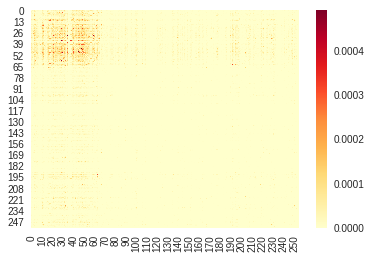

In [74]:
# chart
sns.heatmap(np.abs(interaction_matrix), cmap="YlOrRd", linewidths=0, annot=False, annot_kws={'size': 9}, fmt='.4f');


In [75]:
# print high interaction pairs
# last row, col = bias term
# could also sort, not print out symmetrical pairs
nrows, ncols = interaction_matrix.shape
z = interaction_matrix.copy()[:nrows, :ncols]
z = z.reshape((nrows * ncols))
z.sort()
threshold = z[-100]
print(threshold)
threshold = .0002

for i in range(interaction_matrix.shape[0]-1):
    for j in range(interaction_matrix.shape[1]-1):
        if interaction_matrix[i,j] > threshold:
            print(predictors[i], predictors[j], interaction_matrix[i,j])

0.00018660637
CentralAir TotalSF 0.00028543407
OverallCond GarageQual x GarageCond x GarageCars 0.00020919298
logYearBuilt GarageCars 0.00023640266
logYearBuilt logTotalSF x OverallCond 0.00025481154
YearRemodAdd GarageCars 0.00028675102
YearRemodAdd 1stFlrSF 0.00022506472
GarageCars logYearBuilt 0.00023640276
GarageCars YearRemodAdd 0.00028675102
GarageCars logTotalSF x OverallCond 0.00025656016
GarageCars logFireplaceQu x Fireplaces 0.00025274808
logLotArea logTotalFinSF 0.0003462159
logLotArea logBedRatio 0.00029112698
logLotArea TotalSF x OverallQual x OverallCond 0.00025667617
logLotArea logTotalSF x OverallCond 0.0003214171
sqBsmtUnfSF PorchSF 0.00022294626
1stFlrSF YearRemodAdd 0.00022506462
1stFlrSF TotalSF x OverallQual x OverallCond 0.00020896815
logGrLivArea GarageArea 0.00020764735
logGrLivArea logTotalSF x OverallQual 0.0002105728
GarageArea logGrLivArea 0.00020764742
logTotalFinSF logLotArea 0.00034621556
logTotalFinSF AvgBltRemod 0.00046463232
logTotalFinSF logTotalSF x 

In [76]:
%%time
# tune LightGBM
print("LightGBM")
#n_estimators_lgbm: number of base learner trees
n_estimators_lgbms=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_lgbm = 5623

#max_depth: max depth per base tree
num_leavess = range(2,12)
num_leaves = 5

#subsample: row subsampling rate (similar to RF)
bagging_fractions = np.linspace(0.5, 0.8, 11)
bagging_fraction = 0.75

#colsample_bytree: feature subsampling rate (similar to RF)
feature_fractions = np.linspace(0.05, 0.3, 26)
feature_fraction = 0.1

#learning_rate: shrinkage factor applied to each base tree update
learning_rates = np.logspace(-3, 0, 7)
learning_rates = [0.01]
learning_rate_lgbm = 0.01

for i in [1]:
    print(num_leaves,
          n_estimators_lgbm,
          bagging_fraction,
          feature_fraction,
         )
    
    lgbm = LGBMRegressor(objective='regression',
                         num_leaves=num_leaves,
                         learning_rate=learning_rate_lgbm,
                         n_estimators=n_estimators_lgbm,
                         max_bin=200,
                         bagging_fraction=bagging_fraction,
                         feature_fraction=feature_fraction,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         )
    
    scores = np.sqrt(-cross_val_score(lgbm, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))

    print()

lgbm.fit(X_train, y_train.values.reshape(-1))
y_pred_train = lgbm.predict(X_train)
y_pred_test = lgbm.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)


LightGBM
5 5623 0.75 0.1
CV Score 0.1094 (STD 0.0130)

Train RMSE 7708.217689865049
Train R-squared 0.990207090736871
Train MAE 5549.391337183381

Test RMSE 21040.48001767413
Test R-squared 0.9157739661416345
Test MAE 13162.96238152319
CPU times: user 8min 25s, sys: 5.78 s, total: 8min 31s
Wall time: 58 s


In [77]:
# tune MLPRegressor
print("MLPregressor")

activations = ['relu']
activation = 'relu'

solvers = ['lbfgs']
solver = 'lbfgs'

alphas = np.logspace(0, 2, 3)
alphas = [10]
alpha = 10

learning_rates = ['invscaling']
learning_rate = 'invscaling'

nhiddenlayerss = [1]
nstartlayers = [16, 32, 64, 128,]
layerspecs = product(nhiddenlayerss, nstartlayers)
layerspec = [1, 128]

results_dict = {}

paramlist = product(layerspecs, 
                    activations, 
                    solvers, 
                    alphas, 
                    learning_rates)

mlpmodels = []
for i, (layerspec, activation, solver, alpha, learning_rate) in enumerate(paramlist):
#for i in [1]:
    
    nhiddenlayers, nstartlayer = layerspec
    key = (nhiddenlayers, nstartlayer, alpha)
    mlplayers = []
    for j in range(nhiddenlayers):
        mlplayers.append(nstartlayer)
        nstartlayer = nstartlayer // 4

    print("Iteration %d: %s, %s, %s, alpha = %f, learning rate = %s" % (i,
                            str(mlplayers),
                            activation,
                            solver,
                            alpha,
                            learning_rate,
                           ))
    
    mlp = make_pipeline(use_transform(),
                        MLPRegressor(hidden_layer_sizes=mlplayers,
                                     activation=activation,
                                     solver=solver,
                                     alpha=alpha,
                                     learning_rate=learning_rate,
                                     max_iter=10000))
    
    #print(mlp)
    mlpmodels.append(mlp)
    
    try:
        scores = np.sqrt(-cross_val_score(mlp, df[predictors], df[response],
                                          scoring="neg_mean_squared_error",
                                          cv=kfolds))
        results_dict[key] = np.mean(scores)
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()
    except:
        pass

mlp.fit(X_train, y_train.values.reshape(-1))
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)
try:
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
except:
    pass

MLPregressor
Iteration 0: [16], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1080 (STD 0.0131)

Iteration 1: [32], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1080 (STD 0.0132)

Iteration 2: [64], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1077 (STD 0.0132)

Iteration 3: [128], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1079 (STD 0.0133)

Train RMSE 18305.828446347117
Train R-squared 0.944769043529315
Train MAE 11978.647588373762

Test RMSE 17639.41780137192
Test R-squared 0.9408024739658036
Test MAE 12070.907886250245


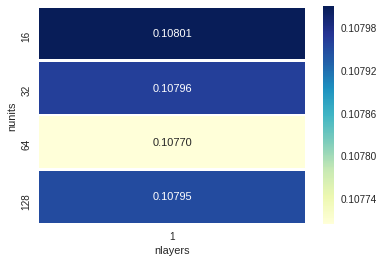

In [78]:
mlp_matrix = pd.DataFrame({
    'nlayers' : [k[0] for k in results_dict.keys()],
    'nunits' : [k[1] for k in results_dict.keys()],
    'alpha' : [np.round(k[2],4) for k in results_dict.keys()],
    'score' : [s for s in results_dict.values()],
})

mlp_pivot = mlp_matrix.pivot_table(index='nunits', 
                                   columns='nlayers',
                                   values='score', 
                                   aggfunc='mean')

sns.heatmap(mlp_pivot, cmap="YlGnBu", linewidths=1.5, annot=True, annot_kws={'size': 11}, fmt='.5f')


### 5. Train and evaluate tuned models on full training set

In [79]:
# drop outliers with big misses before retrain on full training set, so they don't distort test for submission

#outliers = [30, 88, 462, 631, 1322]
# big raw misses 
# outliers = [687, 801, 896, 1320, 631]

outliers = [687, 801, 896, 1320, 1449, 462, 631]
df=df.reset_index(drop=True)
print(df.loc[outliers][response])
print(np.expm1(df.loc[outliers][response]))

687     12.879020
801     13.275829
896     13.323929
1320    11.898195
1449    11.344519
462     11.041064
631     11.320566
Name: SalePrice, dtype: float64
687     392000.0
801     582933.0
896     611657.0
1320    147000.0
1449     84500.0
462      62383.0
631      82500.0
Name: SalePrice, dtype: float64


In [80]:
print(df[predictors].shape)
df.drop(outliers, inplace=True)
# if you don't reset index here, then on assigment of model results some indexes don't line up and you get NAs 
df=df.reset_index(drop=True)
print(df[predictors].shape)
df.tail()

(1456, 255)
(1449, 255)


,MSSubClass,HouseStyle,CentralAir,OverallQual,OverallCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,FireplaceQu,Fence,logYearBuilt,YearRemodAdd,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,logGarageYrBlt,GarageCars,MoSold,LotFrontage,logLotArea,MasVnrArea,sqBsmtUnfSF,TotalBsmtSF,1stFlrSF,sq2ndFlrSF,logGrLivArea,GarageArea,SalePrice,logTotalFinSF,TotalSF,sqBsmtFinSF,PorchSF,TotalBath,BsmtBath,AvgBltRemod,haspool,has2ndfloor,hasfireplace,logLivAreaRatio,logBedRatio,logGarageRatio,logBathRatio,logLotRatio,FireBathRatio,TotalSF x OverallQual x OverallCond,TotalSF x OverallQual x Functional,AvgBltRemod x Functional x TotalFinSF,logTotalSF x OverallQual,logTotalSF x OverallCond,TotalFinSF x Functional,sqFunctional x OverallQual,logAvgBltRemod x OverallCond,logAvgBltRemod x TotalFinSF,logOverallCond x AvgBltRemod,sqBsmtFinSF x BsmtQual,BsmtFinSF x BsmtBath,logKitchenAbvGr x KitchenQual,GarageCars x GarageYrBlt,GarageQual x GarageCond x GarageCars,HeatingQC x Heating,logKitchenQual x KitchenAbvGr,logFireplaceQu x Fireplaces,monthnum,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Alley_0,Alley_1,Alley_2,LandContour_0,LandContour_1,LandContour_2,LandContour_3,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,Neighborhood_0,Neighborhood_1,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_2,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_4,Condition2_6,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_3,RoofMatl_4,RoofMatl_6,Exterior1st_0,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior2nd_1,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_2,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_4,Heating_5,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,MiscFeature_1,MiscFeature_2,MiscFeature_3,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,LotShape_0,LotShape_1,LotShape_2,LandSlope_0,LandSlope_1,LandSlope_2,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_4,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,Electrical_0,Electrical_2,Electrical_3,Electrical_4,KitchenQual_1,KitchenQual_2,KitchenQual_3,KitchenQual_4,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,PavedDrive_0,PavedDrive_1,PavedDrive_2,PoolQC_0,BsmtFullBath_0,BsmtFullBath_1,BsmtFullBath_2,HalfBath_0,HalfBath_1,HalfBath_2,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3
1444,60,5,1,6,5,1,1,1,4,2,0,2.484907,10,2,3,1,7,2.484907,2,8,62.0,8.976894,0.0,908209.0,953.0,953,481636,7.407318,460.0,12.072547,7.407318,2600.0,0.0,40,2.5,0.0,10.5,0,1,1,0.283981,6.309918,0.510826,0.606136,4.857434,0.400000,78000.0,62400.0,69174.0,9.655090,9.472782,6588.0,576,3.979682,9.758144,3.979682,0.0,0.0,1.098612,22,8,20,1.098612,1.098612,19,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,

In [81]:
# store results
full_train_df = pd.DataFrame({'log_y': df[response],
                             'true_y': np.expm1(df[response])
                             })

xval_df = pd.DataFrame({'log_y': df[response],
                       'true_y': np.expm1(df[response])
                       })

cvscores = {}


In [82]:
%%time
# linear models with dummies
models = {
    'lasso'     : lasso,
    'ridge'     : ridge,
    'elasticnet': elasticnet,
    'kr'        : kr,
    'svr'       : svr,
}

for k, m in models.items():
    print(datetime.datetime.now(), k)
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[predictors], df[response])
    full_train_df[k] = m.predict(df[predictors])
    
    print()

2019-06-05 00:07:48.955930 lasso
CV Score 0.0999

2019-06-05 00:07:54.556252 ridge
CV Score 0.1016

2019-06-05 00:08:05.365209 elasticnet
CV Score 0.0999

2019-06-05 00:11:06.854415 kr
CV Score 0.1010

2019-06-05 00:11:07.484309 svr
CV Score 0.0998

CPU times: user 19min 40s, sys: 15.8 s, total: 19min 55s
Wall time: 3min 23s


In [83]:
%%time
# could use simple model specifications w/no dummies - boost, neural net maybe perform slightly better
models = {
    'xgb'       : xgb, 
    'lgbm'      : lgbm,
    'gb'        : gb,
}

for i, m in enumerate(mlpmodels):
    models["mlp%d" % i] = m
    
for k, m in models.items():
    print(datetime.datetime.now(), k)
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[predictors], df[response])
    full_train_df[k] = m.predict(df[predictors])
    
    print()

2019-06-05 00:11:12.411314 xgb
CV Score 0.1045

2019-06-05 00:12:35.406935 lgbm
CV Score 0.1054

2019-06-05 00:13:31.310341 gb
CV Score 0.1035

2019-06-05 00:14:38.198304 mlp0
CV Score 0.1023

2019-06-05 00:14:42.495302 mlp1
CV Score 0.1022

2019-06-05 00:14:49.899132 mlp2
CV Score 0.1021

2019-06-05 00:15:02.968434 mlp3
CV Score 0.1024

CPU times: user 24min 46s, sys: 19 s, total: 25min 5s
Wall time: 4min 13s


In [84]:
blends = {
    'boost_blend': ['xgb', 'lgbm'],
    'linear_blend': ['lasso','ridge','elasticnet','kr'],
    'mlp_blend': ['mlp0', 'mlp1', 'mlp2'],
}

for blend, components in blends.items():
    xval_df[blend] = np.mean(xval_df[components], axis=1)
    full_train_df[blend] = np.mean(full_train_df[components], axis=1)
    cvscores[blend] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[blend]))
    print("%s CV Score %.04f" % (blend, cvscores[blend]))


boost_blend CV Score 0.1041
linear_blend CV Score 0.1001
mlp_blend CV Score 0.1022


### 6. Stack and Blend

In [104]:
%%time
#concatenate raw predictors, blends, and stack with xgb
# something off about this , CV is worse than individual blends
# I think last step maybe should be xval_predict using full train data

df_stack_xval = pd.DataFrame(df[predictors], columns=predictors)
df_stack_xval = pd.concat((df_stack_xval, xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
df_stack_xval = use_transform().fit_transform(df_stack_xval)

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 1000

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 2

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.4

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:

    stack_xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
    display(stack_xgb)

    xval_df['stack_xgb'] = cross_val_predict(stack_xgb,
                                             df_stack_xval, 
                                             xval_df['log_y'], 
                                             cv=kfolds)
    cvscores['stack_xgb'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack_xgb']))
    print("%s CV score %.04f" % ('stack_xgb', cvscores['stack_xgb']))
    
    stack_xgb.fit(df_stack_xval, 
                  xval_df['log_y'])
    
    df_stack_full = pd.DataFrame(df[predictors], columns=predictors)
    df_stack_full = pd.concat((df_stack_full, full_train_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
    df_stack_full = use_transform().fit_transform(df_stack_full)
    
    full_train_df['stack_xgb'] = stack_xgb.predict(df_stack_xval)
    print("%s full train score %.04f" % ('stack_xgb', np.sqrt(mean_squared_error(full_train_df['log_y'], full_train_df['stack_xgb']))))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.15, gamma=0, importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             min_child_weight=0, missing=None, n_estimators=1000, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.4)

stack_xgb CV score 0.1048
stack_xgb full train score 0.0875
CPU times: user 1min 22s, sys: 1.21 s, total: 1min 24s
Wall time: 9.29 s


In [86]:
%%time
# this stack is slow but offers marginal improvement over stacking pre-calculated blends
# with use_features_in_secondary we probably need to scale 

#boost_blend =  VotingRegressor(estimators=[('xgb', xgb), ('lgbm', lgbm)])
#boost_blend.fit(df[predictors], df[response])

#linear_blend = VotingRegressor(estimators=[('lasso', lasso), 
#                                           ('ridge', ridge), 
#                                           ('elasticnet', elasticnet), 
#                                           ('kr', kr)])
#linear_blend.fit(df[predictors], df[response])

#mlp_blend =    VotingRegressor(estimators=[('mlp%d' % i, mlpmodels[i]) for i in range(len(mlpmodels))])
#mlp_blend.fit(df[predictors], df[response])

stack = make_pipeline(use_transform(),
                      StackingCVRegressor(regressors=[xgb, lgbm, 
                                                      lasso, ridge, elasticnet, kr,
                                                      svr, gb
                                                     ] + mlpmodels,
                                          meta_regressor=stack_xgb,
                                          cv=kfolds,
                                          use_features_in_secondary=True))

print(datetime.datetime.now(), "stack xval")
xval_df['stack'] = cross_val_predict(stack, df[predictors].values, df[response].values, cv=kfolds)
print(datetime.datetime.now(), "xval finished")

# compute crossval score
cvscores['stack'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack']))
print(datetime.datetime.now(), "stack crossval score %.6f" % cvscores['stack'])

print(datetime.datetime.now(), "full train")
stack.fit(df[predictors].values, df[response].values)
full_train_df['stack'] = stack.predict(df[predictors].values)
print(datetime.datetime.now(), "full train finished")


2019-06-05 00:15:35.947685 stack xval
2019-06-05 01:27:09.465955 xval finished
2019-06-05 01:27:09.466820 stack crossval score 0.102479
2019-06-05 01:27:09.467073 full train
2019-06-05 01:34:52.235130 full train finished
CPU times: user 7h 37min 54s, sys: 6min 2s, total: 7h 43min 56s
Wall time: 1h 19min 16s


In [105]:
%%time
# stack again using a weighted average.
# 1st level stack does xval_predict using base models and features, meta prediction using base features+predictions
# 2nd level fit lasso model to the base models + stack
# get a weighted avg of all models, no intercept, positive coefs
# on further review, fit_intercept=False screws it up, puts all weight on 1st model, seems like a bug 

# since individual regressors are pipelines that do scaling
# and the metaregressor doesn't use features
# shouldn't need to transform

# note - this should do the same,
# will re-run all models instead of using xval_df (slower and less explicit)
# blendcv = StackingCVRegressor(regressors=blendpredictors,
#                               meta_regressor=blendlasso,
#                               cv=kfolds,
#                               use_features_in_secondary=False)
# blendcv.fit(df[predictors].values, df[response].values)

print(datetime.datetime.now())

# xgb and lgbm correlation > .998
# xval_df['boostblend'] = xval_df[['xgb', 'lgbm']].mean(axis=1)
# full_train_df['boostblend'] = full_train_df[['xgb', 'lgbm']].mean(axis=1)

# linear models correlation > .998
# xval_df['linearblend'] = xval_df[['elasticnet', 'ridge', 'lasso','kr']].mean(axis=1)
# full_train_df['linearblend'] = full_train_df[['elasticnet', 'ridge', 'lasso','kr']].mean(axis=1)

# 3 ML models
# xval_df['mlpblend'] = xval_df[['mlp0', 'mlp1', 'mlp2']].mean(axis=1)
# full_train_df['mlpblend'] = full_train_df[['mlp0', 'mlp1', 'mlp2']].mean(axis=1)

blendlasso = LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=True)
                           
blendpredictors = ['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]
blendlasso.fit(xval_df[blendpredictors],
               xval_df['log_y'])

xval_df['stackblend']=blendlasso.predict(xval_df[blendpredictors])
cvscores['stackblend'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stackblend']))
print("stackblend crossval score %.6f" % cvscores['stackblend'])

full_train_df['stackblend']= blendlasso.predict(full_train_df[blendpredictors])
print("stackblend full train score %.6f" % np.sqrt(mean_squared_error(full_train_df['log_y'], 
                                                                      full_train_df['stackblend'])))
print('coefs', dict(zip(blendpredictors,
                        list(blendlasso.coef_))))
print('coefs adjusted to sum to 1', blendlasso.coef_/np.sum(blendlasso.coef_))
print('intercept', blendlasso.intercept_)
print('sum', np.sum(blendlasso.coef_))
print('alpha', blendlasso.alpha_ )


2019-06-05 10:13:03.281307
stackblend crossval score 0.098007
stackblend full train score 0.076412
coefs {'stack': 0.0, 'stack_xgb': 0.0, 'boost_blend': 0.11870965507991589, 'gb': 0.14182825301504773, 'mlp_blend': 0.0, 'svr': 0.44926817946340886, 'linear_blend': 0.3072239300149057}
coefs adjusted to sum to 1 [0.         0.         0.11672188 0.13945336 0.         0.44174525
 0.30207951]
intercept -0.2082118417271026
sum 1.0170300175732783
alpha 0.0001
CPU times: user 104 ms, sys: 8 ms, total: 112 ms
Wall time: 34.9 ms


In [106]:
xval_df.head()

,log_y,true_y,lasso,ridge,elasticnet,kr,svr,xgb,lgbm,gb,mlp0,mlp1,mlp2,mlp3,boost_blend,linear_blend,mlp_blend,stack_xgb,stack,stackblend
0,12.247699,208500.0,12.247850,12.243149,12.247453,12.244751,12.262510,12.214324,12.223232,12.219128,12.238804,12.239067,12.239498,12.239386,12.218778,12.245801,12.239123,12.238989,12.240070,12.246651
1,12.109016,181500.0,12.143098,12.166773,12.143269,12.167585,12.130380,12.126831,12.084449,12.097206,12.163868,12.162342,12.163272,12.164025,12.105640,12.155181,12.163160,12.124965,12.112983,12.128726
2,12.317171,223500.0,12.283429,12.279485,12.282219,12.275969,12.288238,12.259110,12.266719,12.273699,12.286464,12.288365,12.287371,12.287547,12.262914,12.280275,12.287400,12.270966,12.268683,12.281781
3,11.849405,140000.0,12.038342,11.993997,12.042499,11.992597,12.020678,12.074079,12.087849,12.067509,11.995095,11.995700,11.997564,11.993526,12.080964,12.016859,11.996119,12.079416,12.053489,12.029803
4,12.429220,250000.0,12.573445,12.567470,12.573386,12.567409,12.562323,12.564583,12.567876,12.561018,12.569477,12.571129,12.571639,12.568595,12.566229,12.570428,12.570748,12.566019,12.567281,12.570816


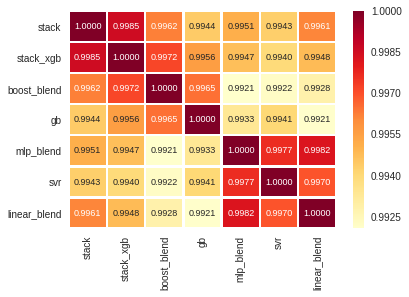

In [107]:
xval_corr = xval_df[blendpredictors].corr()
sns.heatmap(xval_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


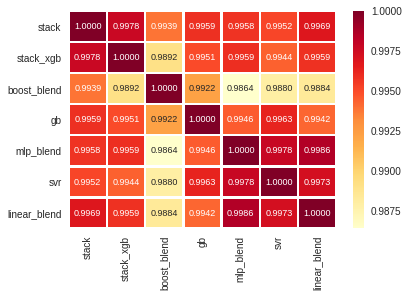

In [108]:
full_train_corr = full_train_df[['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]].corr()
sns.heatmap(full_train_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [109]:
## review final CV scores

for col in xval_df.columns:
    if col in ['true_y', 'log_y', 'true_pred', 'error_stackblend']:
        continue
        
    print(col)
    evaluate2(xval_df[col], xval_df['log_y'])
    print('CV:', cvscores.get(col))
    print()


lasso
Train RMSE (log) 0.09994273983514804
Train RMSE 17661.126583517856
Train R-squared 0.9406341963081755
Train MAE 11859.908230869523
CV: 0.09994273983514804

ridge
Train RMSE (log) 0.10163744353844051
Train RMSE 17818.23200570252
Train R-squared 0.9397888929957359
Train MAE 11978.970265007913
CV: 0.10163744353844051

elasticnet
Train RMSE (log) 0.09986185949004617
Train RMSE 17637.08491972355
Train R-squared 0.9407384378860264
Train MAE 11842.289371853392
CV: 0.09986185949004617

kr
Train RMSE (log) 0.1009894509973786
Train RMSE 17787.496346140917
Train R-squared 0.9402765695594538
Train MAE 11950.838008976334
CV: 0.1009894509973786

svr
Train RMSE (log) 0.09984685223576509
Train RMSE 17665.420809617244
Train R-squared 0.9388030481861556
Train MAE 11533.034509825025
CV: 0.09984685223576509

xgb
Train RMSE (log) 0.10452260791809224
Train RMSE 19787.499779802125
Train R-squared 0.9230473892871419
Train MAE 12538.524936378542
CV: 0.10452260791809224

lgbm
Train RMSE (log) 0.1054375533

In [110]:
full_train_df['error_log'] = full_train_df['stackblend'] - full_train_df['log_y']
full_train_df['true_y'] = np.expm1(full_train_df['log_y'])
full_train_df['true_pred'] = np.expm1(full_train_df['stackblend'])
full_train_df['error_stackblend'] = full_train_df['true_pred'] - full_train_df['true_y']
full_train_df.describe()


,log_y,true_y,lasso,ridge,elasticnet,kr,svr,xgb,lgbm,gb,mlp0,mlp1,mlp2,mlp3,boost_blend,linear_blend,mlp_blend,stack_xgb,stack,stackblend,error_log,true_pred,error_stackblend,bias_adjustment
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,12.021308,179666.820566,12.021308,12.021308,12.021308,12.021264,12.026895,12.021281,12.021308,12.025000,12.021324,12.021321,12.021309,12.021330,12.021300,12.021297,12.021318,12.020829,12.020773,12.020849,-0.000459,179120.880964,-545.939602,-0.003043
std,0.391841,74938.007771,0.379391,0.380038,0.379644,0.380363,0.372859,0.386525,0.385014,0.376193,0.376917,0.376941,0.377068,0.376919,0.385681,0.379771,0.376939,0.377493,0.379808,0.382559,0.076437,73771.323535,13079.052761,0.015344
min,10.460271,34900.000000,10.670764,10.670445,10.669245,10.674681,10.669395,10.486106,10.481629,10.843563,10.662824,10.659629,10.645108,10.659604,10.483867,10.686112,10.655854,10.661060,10.739676,10.665631,-0.358674,42856.304500,-84864.517421,-0.179333
25%,11.775297,130000.000000,11.763312,11.769357,11.763096,11.770828,11.773053,11.779688,11.779237,11.779048,11.762936,11.761633,11.768058,11.762320,11.779196,11.766685,11.765746,11.774857,11.780685,11.766894,-0.040207,128912.142041,-6466.928646,0.000000
50%,12.001512,163000.000000,12.008593,11.999928,12.006534,12.000351,12.002097,12.000831,11.998698,11.999777,12.001794,12.000422,12.000955,12.000134,11.999721,12.002052,12.001467,11.997411,11.995221,11.997919,-0.003191,162415.462036,-524.808294,0.000000
75%,12.271397,213500.000000,12.269018,12.273140,12.268202,12.272856,12.264251,12.260221,12.258563,12.256095,12.267101,12.266743,12.261238,12.266479,12.262036,12.268807,12.265045,12.260302,12.260072,12.264736,0.031774,212082.690832,5250.283554,0.000000
max,13.345509,625000.000000,13.314861,13.338930,13.316703,13.337138,13.313793,13.332947,13.324987,13.278463,13.344266,13.360116,13.371029,13.358220,13.328967,13.326908,13.358470,13.161882,13.142883,13.333135,0.631550,617314.317758,84480.850866,0.000000


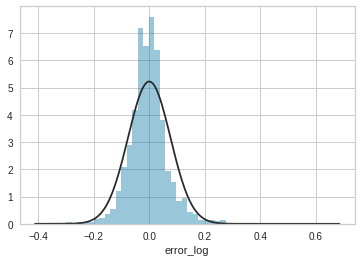

In [111]:
# plot save residuals to analyze vs. columns, interactions
residual = full_train_df[['log_y','true_y', 'true_pred', 'stackblend', 'error_stackblend', 'error_log']]
residual.reset_index(inplace=True)
residual['index'] += 1
residual.to_csv('residual_temp.csv', index=False)

sns.distplot(residual['error_log'], kde=False, fit=stats.norm)


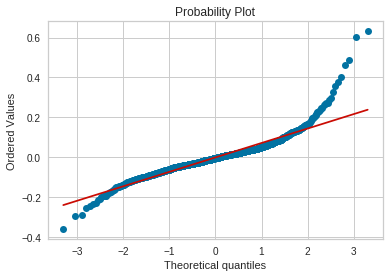

In [112]:
res = stats.probplot(residual['error_log'], plot=plt);

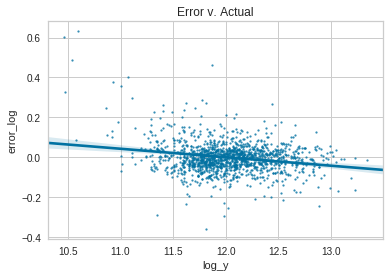

In [113]:
sns.regplot(x="log_y", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Actual');


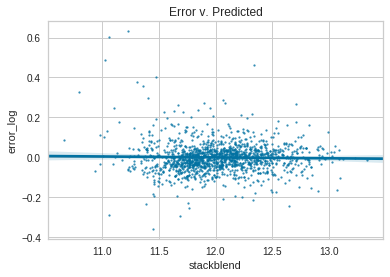

In [114]:
sns.regplot(x="stackblend", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Predicted');

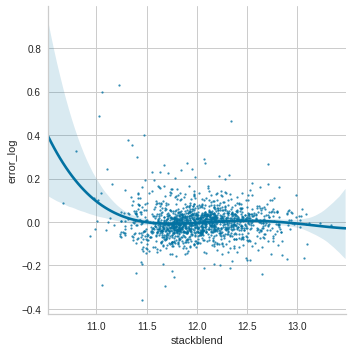

In [115]:
sns.lmplot(x="stackblend", y="error_log", data=residual,
           order=4, scatter_kws={"s": 5});

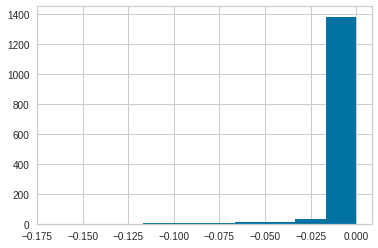

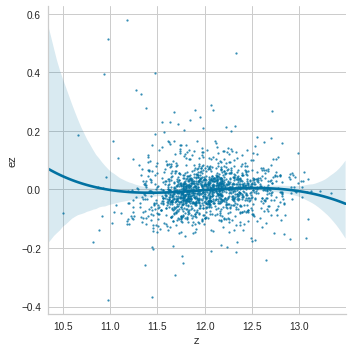

In [116]:
# maybe worth making a kludgy adjustment 
# there might be a more systematic way of forcing toward a prior distribution
full_train_df['bias_adjustment'] = (full_train_df['stackblend'] - 11.5) * 0.2
full_train_df['bias_adjustment'] = full_train_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
full_train_df['bias_adjustment'].hist()
residual['z'] = full_train_df['stackblend'] + full_train_df['bias_adjustment']
residual['ez'] = residual['z'] - residual['log_y']

sns.lmplot(x="z", y="ez", data=residual,
           order=4, scatter_kws={"s": 5});

In [117]:
full_train_df.sort_values('error_stackblend')[['true_y','true_pred','error_stackblend', 'error_log']]
full_train_df.sort_values('error_log')[['true_y','true_pred','error_stackblend', 'error_log']]


,true_y,true_pred,error_stackblend,error_log
963,135000.0,94310.975658,-40689.024342,-0.358674
678,159434.0,118960.702689,-40473.297311,-0.292835
88,85000.0,63648.044212,-21351.955788,-0.289279
142,166000.0,129014.164281,-36985.835719,-0.252064
769,395000.0,310135.482579,-84864.517421,-0.241876
1115,112000.0,88453.086642,-23546.913358,-0.236024
487,160000.0,127357.539462,-32642.460538,-0.228174
13,279500.0,225692.458671,-53807.541329,-0.213828
328,214500.0,173879.265063,-40620.734937,-0.209947
858,250580.0,205535.499221,-45044.500779,-0.198159


### 7. Run on test set, export CSV for submission

In [122]:
# raw models

submit_df = pd.DataFrame({'xgb'       : xgb.predict(df_test[predictors]), 
                          'lgbm'      : lgbm.predict(df_test[predictors]),
                          'gb'        : gb.predict(df_test[predictors]),
                          'svr'       : svr.predict(df_test[predictors]),
                          'lasso'     : lasso.predict(df_test[predictors]),
                          'ridge'     : ridge.predict(df_test[predictors]),
                          'elasticnet': elasticnet.predict(df_test[predictors]),
                          'kr'        : kr.predict(df_test[predictors]),
                          'stack'     : stack.predict(df_test[predictors])
                         })
for i, m in enumerate(mlpmodels):
    submit_df["mlp%d" % i] = m.predict(df_test[predictors])

#blends

for blend, components in blends.items():
    submit_df[blend] = np.mean(submit_df[components], axis=1)

# fix ids to line up with test
submit_df.reset_index(inplace=True)
submit_df.rename(columns={'index': 'Id'}, inplace=True)
submit_df['Id']+=1461
submit_df.set_index('Id', inplace=True)
                    
# create stack dataset

submit_stack = pd.DataFrame(df_test[predictors],
                            columns=predictors)
submit_stack = pd.concat((submit_stack, submit_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
submit_stack = use_transform().fit_transform(submit_stack)
submit_df['stack_xgb'] = stack_xgb.predict(submit_stack)

# blend prediction
submit_df['stackblend']=blendlasso.predict(submit_df[blendpredictors])

# force weights to sum to 1, no intercept
submit_df['stackblend2'] = \
     0.0 * submit_df['stack'] + \
     0.0        * submit_df['stack_xgb'] + \
     0.11624497  * submit_df['boost_blend'] + \
     0.14042318 * submit_df['gb']  + \
     0.0        * submit_df['mlp_blend'] + \
     0.43958809 * submit_df['svr'] + \
     0.30374377 * submit_df['linear_blend']

# alternate rounded weights , floor at 0.05, cap at 0.25
# the stack and a linear model are usually in the top tier, svr and gb are often up there, want to include all
submit_df['stackblend3'] = \
     0.20       * submit_df['stack'] + \
     0.10       * submit_df['boost_blend'] + \
     0.10       * submit_df['gb'] + \
     0.10       * submit_df['mlp_blend'] +\
     0.25       * submit_df['svr'] + \
     0.25       * submit_df['linear_blend'] 

submit_df.head()


,xgb,lgbm,gb,svr,lasso,ridge,elasticnet,kr,stack,mlp0,mlp1,mlp2,mlp3,boost_blend,linear_blend,mlp_blend,stack_xgb,stackblend,stackblend2,stackblend3
Id,,,,,,,,,,,,,,,,,,,,
1461,11.760212,11.754393,11.742586,11.675680,11.657482,11.644678,11.655912,11.647590,11.707093,11.639261,11.634058,11.643410,11.634688,11.757303,11.651415,11.638910,11.741315,11.678029,11.687193,11.687072
1462,12.002229,12.005834,11.991735,11.978205,11.957131,11.943612,11.955110,11.942451,11.954218,11.951187,11.953779,11.960347,11.953896,12.004031,11.949576,11.955104,12.001665,11.970172,11.974411,11.967876
1463,12.132675,12.138251,12.152229,12.143174,12.126498,12.122020,12.125219,12.122834,12.106142,12.121361,12.117126,12.113707,12.121099,12.135463,12.124143,12.117398,12.127686,12.136283,12.137769,12.128567
1464,12.202227,12.209882,12.207048,12.197300,12.200958,12.186165,12.199251,12.187167,12.169841,12.194989,12.184203,12.177367,12.186290,12.206055,12.193385,12.185520,12.193713,12.198027,12.198497,12.191502
1465,12.128362,12.154343,12.144959,12.087724,12.101351,12.100448,12.102950,12.101466,12.112930,12.073312,12.082788,12.082055,12.082095,12.141352,12.101554,12.079385,12.170514,12.104099,12.106196,12.106475


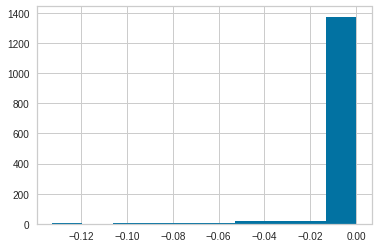

In [123]:
submit_df['bias_adjustment'] = (submit_df['stackblend'] - 11.5) * 0.2
submit_df['bias_adjustment'] = submit_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
submit_df['stackblend_adjust'] = submit_df['stackblend'] + submit_df['bias_adjustment']
submit_df['stackblend3_adjust'] = submit_df['stackblend3'] + submit_df['bias_adjustment']
submit_df['bias_adjustment'].hist()

In [124]:
submit_df =np.expm1(submit_df)
submit_df.describe()


,xgb,lgbm,gb,svr,lasso,ridge,elasticnet,kr,stack,mlp0,mlp1,mlp2,mlp3,boost_blend,linear_blend,mlp_blend,stack_xgb,stackblend,stackblend2,stackblend3,bias_adjustment,stackblend_adjust,stackblend3_adjust
count,1459.000000,1459.000000,1459.000000,1459.000000,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1459.000000,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1459.000000,1.459000e+03,1.459000e+03,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,178623.770924,178703.602053,179170.090991,179392.211776,1.797562e+05,1.798806e+05,1.797617e+05,1.798841e+05,178281.199379,1.797469e+05,1.798320e+05,1.800851e+05,1.798517e+05,178649.844563,1.798135e+05,1.798818e+05,183102.804027,179028.711592,179167.057674,178989.528831,-0.003023,178812.158520,178773.212089
std,77429.805606,78250.228520,77267.552067,77003.137798,8.959264e+04,8.993051e+04,8.925850e+04,9.004191e+04,76494.206983,9.136045e+04,9.154340e+04,9.604499e+04,9.224030e+04,77787.843291,8.968334e+04,9.285801e+04,76316.716420,79162.963256,77725.646841,78049.081266,0.013622,79455.699620,78345.199718
min,44125.661609,38337.117137,56487.596210,55468.806345,4.125569e+04,4.522785e+04,4.115812e+04,4.433316e+04,48600.815648,5.137906e+04,5.134704e+04,5.109699e+04,5.125741e+04,41129.683457,4.295547e+04,5.127421e+04,49932.961917,50861.192309,52036.541208,51162.178732,-0.124207,44543.776306,44807.378252
25%,128262.653560,128968.633482,129021.873386,127801.665696,1.260245e+05,1.259560e+05,1.260543e+05,1.260275e+05,128775.223452,1.262245e+05,1.253872e+05,1.269566e+05,1.256856e+05,128688.697004,1.261856e+05,1.261081e+05,132598.019458,126260.071570,127276.402824,127480.739536,0.000000,126260.071570,127480.739536
50%,157391.714697,157158.849709,157551.257685,159131.082984,1.585412e+05,1.580294e+05,1.582511e+05,1.580090e+05,155224.598420,1.580717e+05,1.582867e+05,1.582527e+05,1.581194e+05,157376.279258,1.582627e+05,1.580397e+05,162303.980030,157405.283146,158078.565293,157383.946772,0.000000,157405.283146,157383.946772
75%,210182.028608,210842.392143,209042.308861,209775.356392,2.113872e+05,2.118260e+05,2.110163e+05,2.115680e+05,210736.161962,2.099495e+05,2.101370e+05,2.093957e+05,2.096736e+05,210064.550718,2.115251e+05,2.096681e+05,216161.044748,210685.345728,210564.787158,210360.483052,0.000000,210685.345728,210360.483052
max,605060.603642,675147.452285,663693.924746,557428.953910,1.864499e+06,1.834930e+06,1.830552e+06,1.837473e+06,494889.605495,2.023531e+06,2.008812e+06,2.317202e+06,2.055141e+06,639144.058055,1.841816e+06,2.111889e+06,496301.373181,565815.323299,556325.270174,666761.914643,0.000000,565815.323299,666761.914643


In [125]:
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['boost_blend']}).to_csv('boost_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['linear_blend']}).to_csv('linear_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['mlp_blend']}).to_csv('mlp_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['svr']}).to_csv('svr.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['gb']}).to_csv('gb.csv', index=False)

pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend']}).to_csv('stackblend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack']}).to_csv('stack.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack_xgb']}).to_csv('stack_xgb.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend2']}).to_csv('stackblend2.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3']}).to_csv('stackblend3.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend_adjust']}).to_csv('stackblend_adjust.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3_adjust']}).to_csv('stackblend3_adjust.csv', index=False)

print(datetime.datetime.now())


2019-06-05 10:17:03.975429


 ### If you got this far 
 - At time of writing 05/2019 there are 2 Kaggle contests using this data
     - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard
     - https://www.kaggle.com/c/home-data-for-ml-course/leaderboard
 - 1st contest is tougher leaderboard, this solution is about .115 log error, #250 / 4500, 
 - Maybe top 5% after accounting for blenders and cheaters LOL
     - looking at people who posted top kernels, some of them blend with other people's results
     - and data is publicly available so it's possible to look up solutions for the test set
 - 2nd contest (InClass) is softer leaderboard, this solution came in about 12500 raw error, rank 30/5000, top 2%
 - Observing that other people blended, I blended output from this with 3 other top kernels:
    - https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force
    - https://www.kaggle.com/couyang/hybrid-svm-benchmark-approach-0-11180-lb-top-2
    - https://www.kaggle.com/zavodrobotov/lasso-model-for-regression-problem
 - Blend achieved #156 and #3 on 2 leaderboards 0.110, 12100
 - Seems pointless to blend but was curious how high I could go
 - Could maybe improve raw model a little further
     - A very careful visual or systematic examination of which predictors should be dummified, transformed
     - Systematic elimination of non-helpful predictors
     - Add additional models, for averaging, stacking
 - Pretty curious how top results were achieved, quite a few in .1106 range, brute force, more clever features, or just blending top kernels?
 